## **Análise Exploratória de Dados (EDA) e Tratamento de Dados Faltantes no Conjunto de Dados AirQualityUCI**

Este conjunto de dados contém respostas médias horárias de um conjunto de 5 sensores químicos de óxido de metal incorporados em um Dispositivo Multisensor Químico de Qualidade do Ar. Os dados foram registrados de março de 2004 a fevereiro de 2005 (um ano) em uma área significativamente poluída, ao nível da estrada, dentro de uma cidade italiana. As concentrações horárias verdadeiras de CO, Hidrocarbonetos Não Metânicos, Benzeno, NOx totais e NO2 foram fornecidas por um analisador de referência coexistente. Temperatura do ar, umidade relativa e umidade absoluta também foram registradas.

Os valores faltantes são marcados com o valor -200.

Vamos começar carregando os dados e fazendo uma inspeção inicial.

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar o conjunto de dados
# O arquivo CSV parece ter um nome composto, vamos usar o nome correto.
base_dir = os.path.join('..', 'Data', 'air+quality')
file_path = os.path.join(base_dir, 'AirQualityUCI.csv')

# Ler o arquivo CSV
# O arquivo CSV parece ter um separador diferente, vamos especificar o separador correto.
df = pd.read_csv(file_path, sep=';', decimal=',', na_values=-200)

# Inspecionar as primeiras linhas
print("Primeiras 5 linhas do DataFrame:")
print(df.head)

# Inspecionar as primeiras linhas
print("Primeiras 5 linhas do DataFrame:")
print(df.head())
print("\nÚltimas 5 linhas do DataFrame para verificar dados faltantes no final:")
print(df.tail())

# Informações gerais sobre o DataFrame
print("\nInformações do DataFrame:")
df.info()

# Verificar as dimensões do dataset
print("\nDimensões do DataFrame (linhas, colunas):")
print(df.shape)

Primeiras 5 linhas do DataFrame:
<bound method NDFrame.head of             Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0     10/03/2004  18.00.00     2.6       1360.0     150.0      11.9   
1     10/03/2004  19.00.00     2.0       1292.0     112.0       9.4   
2     10/03/2004  20.00.00     2.2       1402.0      88.0       9.0   
3     10/03/2004  21.00.00     2.2       1376.0      80.0       9.2   
4     10/03/2004  22.00.00     1.6       1272.0      51.0       6.5   
...          ...       ...     ...          ...       ...       ...   
9466         NaN       NaN     NaN          NaN       NaN       NaN   
9467         NaN       NaN     NaN          NaN       NaN       NaN   
9468         NaN       NaN     NaN          NaN       NaN       NaN   
9469         NaN       NaN     NaN          NaN       NaN       NaN   
9470         NaN       NaN     NaN          NaN       NaN       NaN   

      PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
0            10

**Observações Iniciais da Carga dos Dados:**

O arquivo CSV foi carregado. A inspeção inicial do df.info() e df.head() nos dirá se o separador correto foi inferido ou se precisamos especificá-lo.
O df.tail() pode nos dar uma pista sobre como os dados terminam, especialmente se houver linhas completamente vazias no final.
df.info() mostrará os tipos de dados de cada coluna e a contagem de valores não nulos. Se colunas numéricas estiverem como object, pode indicar problemas de parseamento ou a presença de valores não numéricos misturados (além do -200 que trataremos).

Após a execução do código acima, a saída de df.info() revelou que algumas colunas que deveriam ser numéricas foram lidas como object. Isso geralmente acontece quando há caracteres não numéricos (como vírgulas usadas como separadores decimais em vez de pontos) nas colunas. Além disso, o arquivo CSV pode ter linhas vazias no final, como indicado pela forma e pelas contagens de não nulos.

Vamos refinar o carregamento dos dados:

1. Identificar quais colunas foram lidas como object e deveriam ser numéricas.
2. Converter essas colunas para numéricas, tratando erros de conversão.
3. Substituir os valores -200 por NaN (Not a Number) para que o pandas possa reconhecê-los como ausentes.
4. Combinar as colunas Date e Time em uma única coluna DateTime do tipo datetime.
5. Remover colunas completamente vazias, se houver.





In [6]:
# Recarregar o arquivo com tratamento adequado para decimais e valores faltantes
# O dataset original usa '.' para horas e ',' para decimais em algumas colunas.
# Além disso, valores faltantes são -200.

# Verificar se as duas últimas colunas estão completamente vazias (como é comum neste dataset)
if df.iloc[:, -1].isnull().all() and df.iloc[:, -2].isnull().all():
    print("\nAs duas últimas colunas estão completamente vazias e serão removidas.")
    df = df.iloc[:, :-2]  # Remover as duas últimas colunas
else:
    print("\nAs duas últimas colunas não estão completamente vazias e não serão removidas.")
# Substituir -200 por NaN
df.replace(to_replace=-200, value=np.nan, inplace=True)

# Converter colunas para numérico. Algumas colunas podem estar como 'object' devido a ',' como decimal.
# Vamos iterar pelas colunas que deveriam ser numéricas.
# As colunas de 'Date' e 'Time' são as duas primeiras. O resto deveria ser numérico.
cols_to_convert = df.columns[2:]

for col in cols_to_convert:
    if df[col].dtype == 'object':
        # Tentar substituir vírgula por ponto e converter para float
        df[col] = df[col].str.replace(',', '.').astype(float)
    elif pd.api.types.is_integer_dtype(df[col]) or pd.api.types.is_float_dtype(df[col]):
        # Se já for numérico, converter para float para consistência e para acomodar NaNs
        df[col] = df[col].astype(float)

# Combinar 'Date' e 'Time' em uma coluna DateTime
# Verificar se as colunas 'Date' e 'Time' existem
if 'Date' in df.columns and 'Time' in df.columns:
    try:
        df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')
        # Definir DateTime como índice
        df.set_index('DateTime', inplace=True)
        # Remover colunas originais de Data e Hora
        df.drop(['Date', 'Time'], axis=1, inplace=True, errors='ignore') # errors='ignore' para caso já tenham sido removidas
        print("\nColunas 'Date' e 'Time' combinadas em 'DateTime' e definidas como índice.")
    except Exception as e:
        print(f"\nErro ao combinar Date e Time: {e}")
        print("Verificando as primeiras linhas das colunas 'Date' e 'Time' para diagnóstico:")
        print(df[['Date', 'Time']].head())
else:
    print("\nColunas 'Date' ou 'Time' não encontradas. Verifique os nomes das colunas.")


# Remover linhas onde 'Date' ou 'Time' são NaT (após a tentativa de combinação) ou se sobraram colunas com todos NaNs
df.dropna(axis=0, how='all', subset=df.columns.drop(['Date', 'Time'], errors='ignore'), inplace=True)


print("\nInformações do DataFrame após limpeza inicial:")
df.info()

print("\nPrimeiras 5 linhas do DataFrame após limpeza:")
print(df.head())

# Estatísticas Descritivas
print("\nEstatísticas Descritivas (após converter -200 para NaN):")
print(df.describe())


As duas últimas colunas estão completamente vazias e serão removidas.

Colunas 'Date' e 'Time' combinadas em 'DateTime' e definidas como índice.

Informações do DataFrame após limpeza inicial:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9326 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         7674 non-null   float64
 1   PT08.S1(CO)    8991 non-null   float64
 2   NMHC(GT)       914 non-null    float64
 3   C6H6(GT)       8991 non-null   float64
 4   PT08.S2(NMHC)  8991 non-null   float64
 5   NOx(GT)        7718 non-null   float64
 6   PT08.S3(NOx)   8991 non-null   float64
 7   NO2(GT)        7715 non-null   float64
 8   PT08.S4(NO2)   8991 non-null   float64
 9   PT08.S5(O3)    8991 non-null   float64
 10  T              8991 non-null   float64
 11  RH             8991 non-null   float64
 12  AH             8991 non-null   float64
dty

## **Análise das Estatísticas Descritivas e Tipos de Dados:**
Com os dados carregados e os valores -200 convertidos para NaN, as estatísticas descritivas (df.describe()) nos darão uma visão melhor das distribuições de cada sensor e variável meteorológica, incluindo a contagem real de dados não ausentes.



1. **Análise de Dados Faltantes**
Agora, vamos analisar a quantidade e a porcentagem de dados faltantes em cada coluna.


Contagem de valores faltantes por coluna:
CO(GT)           1652
PT08.S1(CO)       335
NMHC(GT)         8412
C6H6(GT)          335
PT08.S2(NMHC)     335
NOx(GT)          1608
PT08.S3(NOx)      335
NO2(GT)          1611
PT08.S4(NO2)      335
PT08.S5(O3)       335
T                 335
RH                335
AH                335
dtype: int64

Porcentagem de valores faltantes por coluna:
NMHC(GT)         90.199442
CO(GT)           17.713918
NO2(GT)          17.274287
NOx(GT)          17.242119
PT08.S1(CO)       3.592108
PT08.S2(NMHC)     3.592108
C6H6(GT)          3.592108
PT08.S3(NOx)      3.592108
PT08.S4(NO2)      3.592108
PT08.S5(O3)       3.592108
T                 3.592108
RH                3.592108
AH                3.592108
dtype: float64


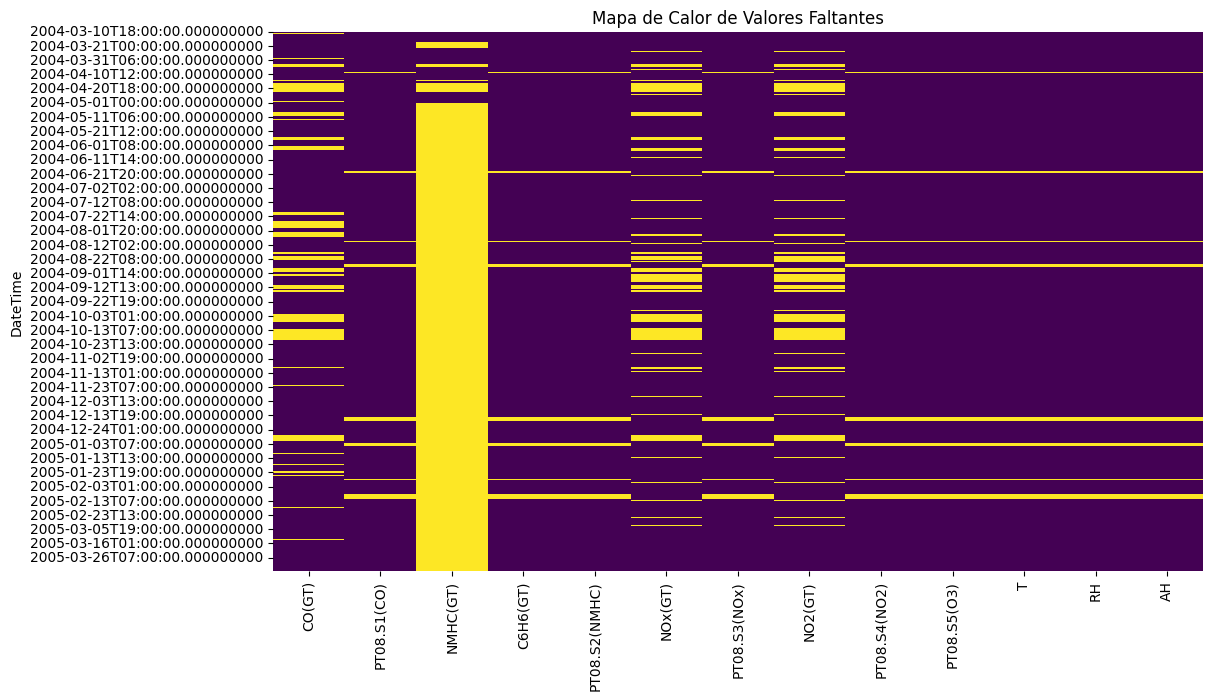

In [7]:
# Contagem de valores faltantes por coluna
missing_values_count = df.isnull().sum()
print("\nContagem de valores faltantes por coluna:")
print(missing_values_count)

# Porcentagem de valores faltantes por coluna
total_rows = len(df)
missing_values_percentage = (missing_values_count / total_rows) * 100
print("\nPorcentagem de valores faltantes por coluna:")
print(missing_values_percentage.sort_values(ascending=False))

# Visualização de dados faltantes
plt.figure(figsize=(12, 7))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Mapa de Calor de Valores Faltantes')
plt.show()

## **Observações sobre Dados Faltantes:**

* A coluna NMHC(GT) (Hidrocarbonetos Não Metânicos) geralmente possui uma quantidade muito grande de dados faltantes neste dataset (cerca de 90%). Se for o caso, pode ser uma candidata à remoção.
* Outras colunas também terão dados faltantes, mas em menor grau. A visualização do heatmap ajudará a identificar padrões (por exemplo, se os dados faltantes ocorrem em blocos).

**2. Análise Univariada**

Vamos analisar a distribuição de cada variável individualmente.



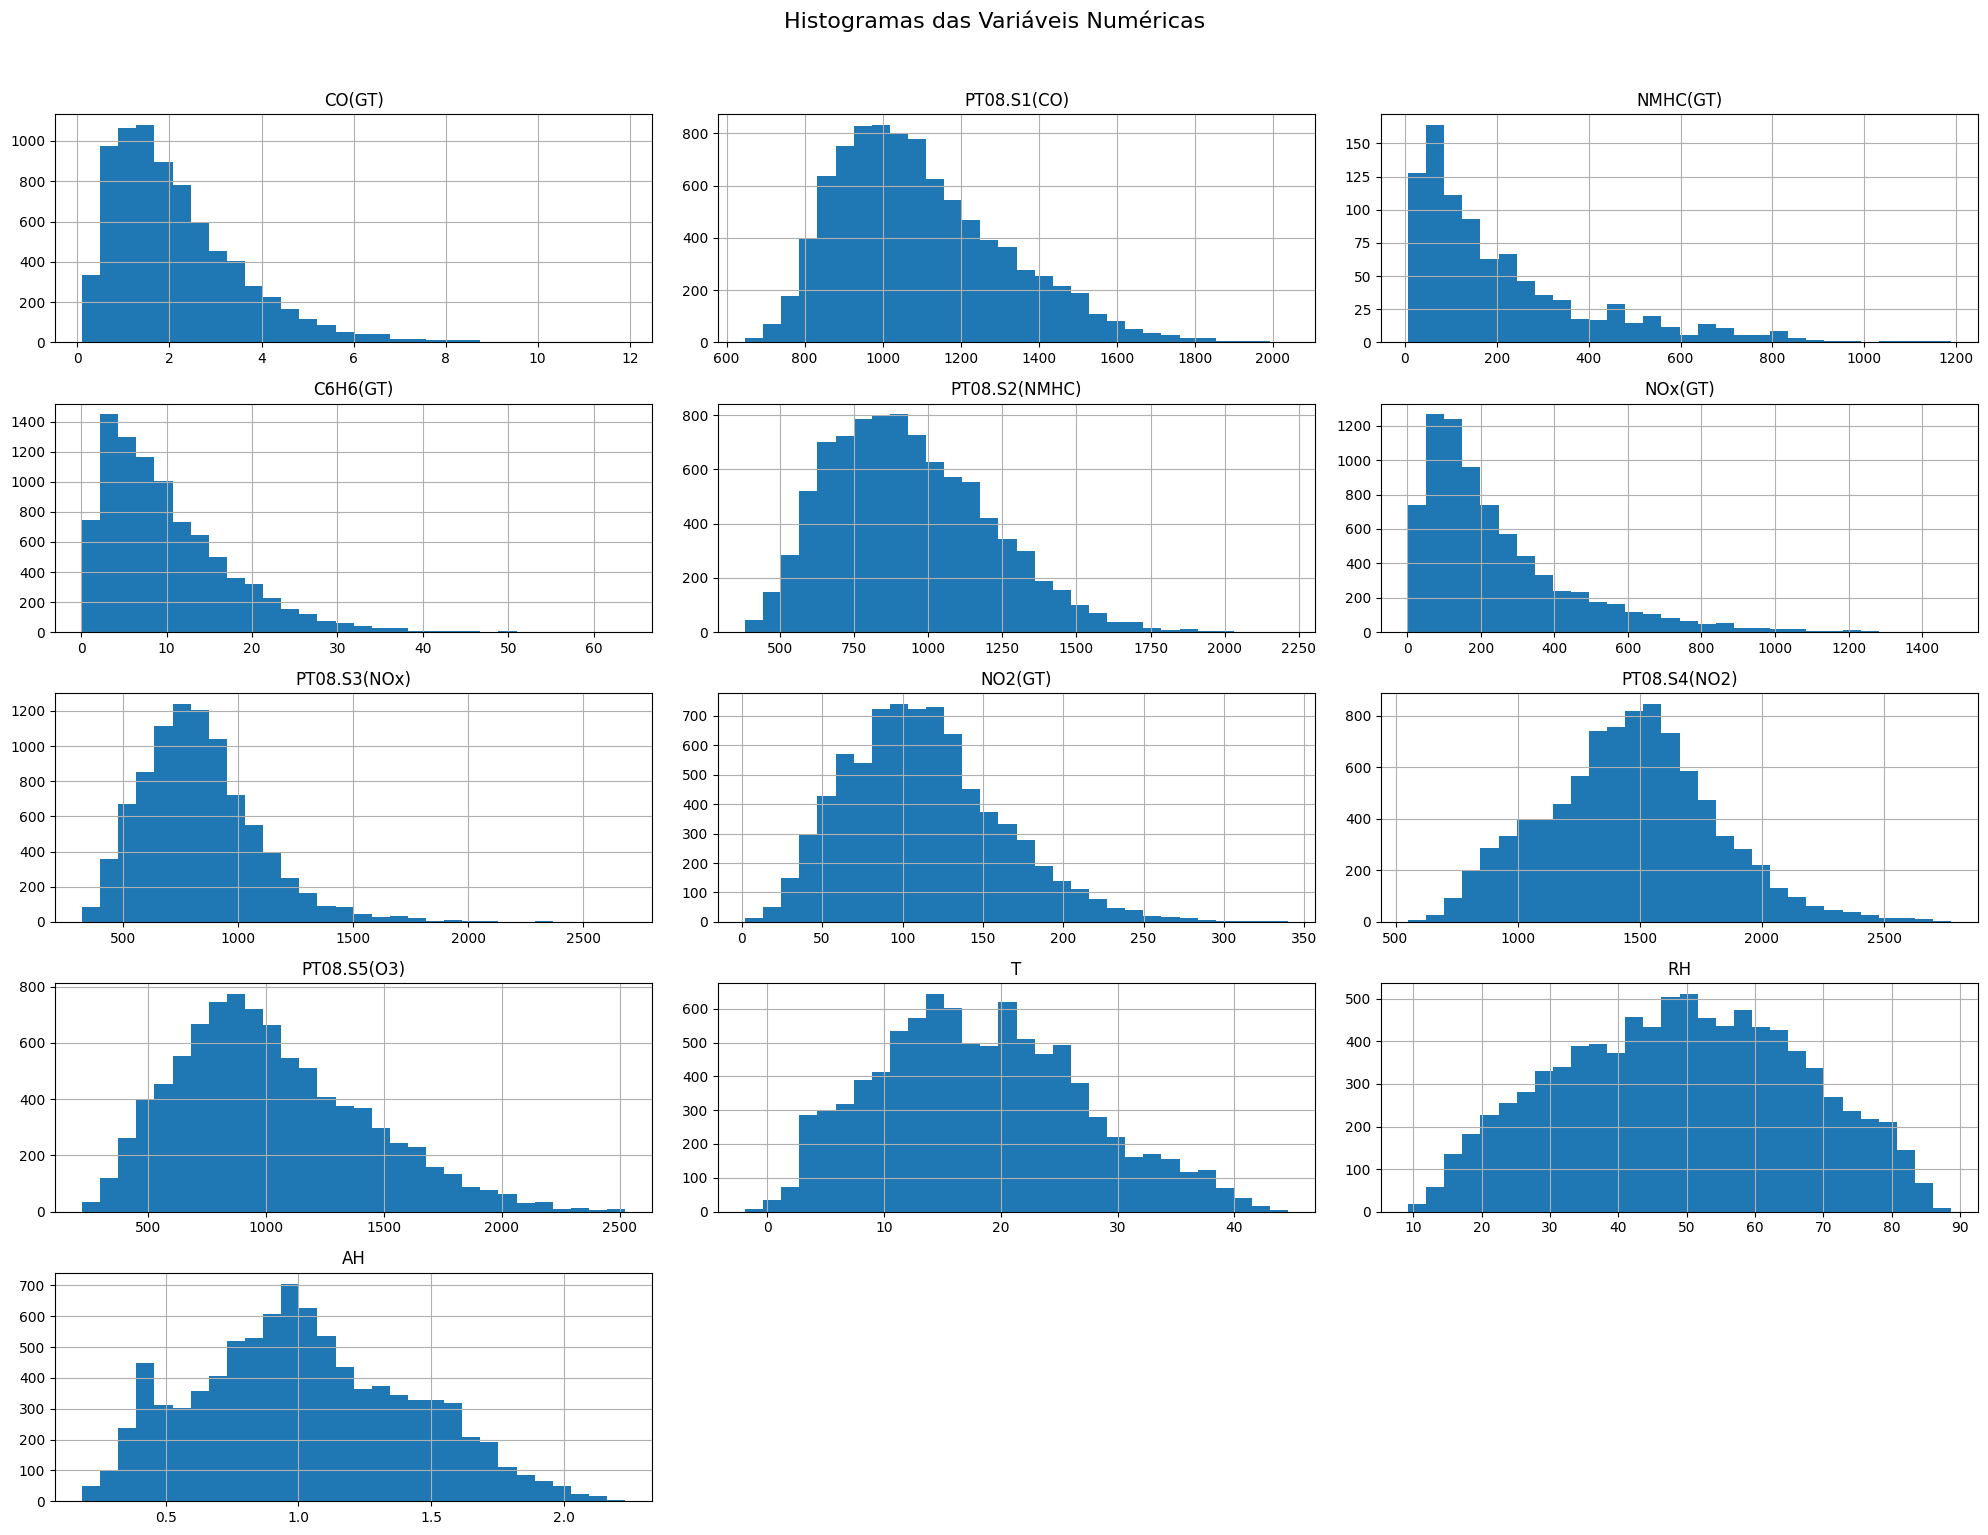

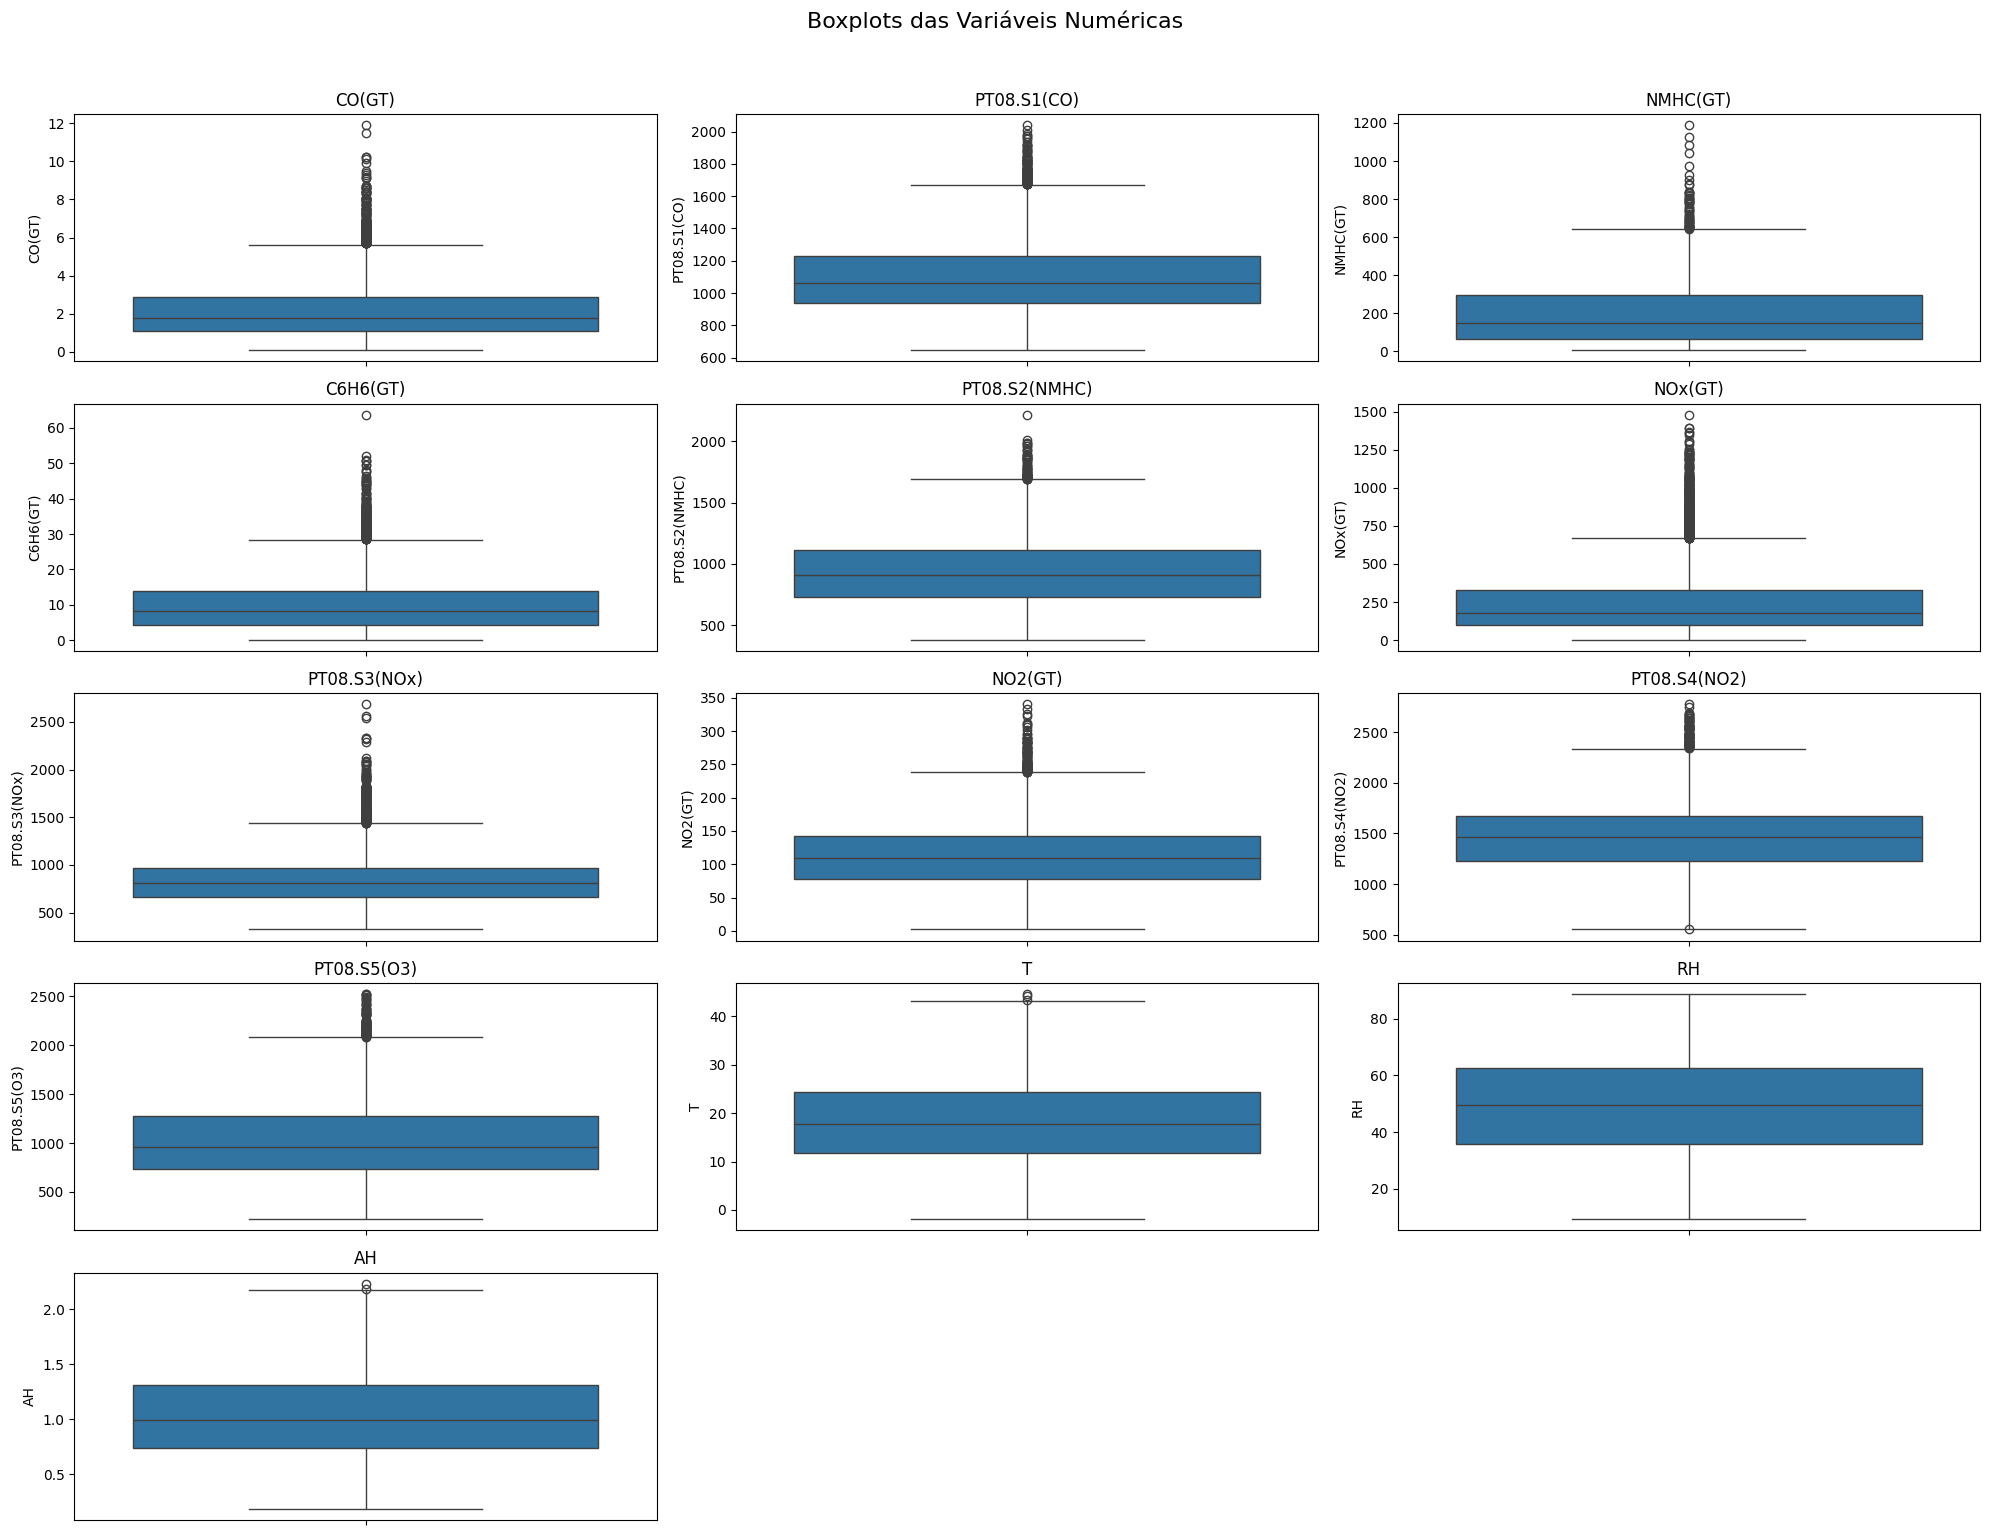

In [8]:
# Selecionar apenas colunas numéricas para histogramas (todas devem ser após o tratamento)
numeric_cols = df.select_dtypes(include=np.number).columns

# Plotar histogramas para cada variável numérica
df[numeric_cols].hist(bins=30, figsize=(20, 15), layout=(-1, 3))
plt.suptitle('Histogramas das Variáveis Numéricas', y=1.02, size=16)
plt.tight_layout()
plt.show()

# Plotar boxplots para identificar outliers
plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_cols):
    plt.subplot(5, 3, i + 1) # Ajustar layout conforme o número de colunas
    sns.boxplot(y=df[col])
    plt.title(col)
plt.suptitle('Boxplots das Variáveis Numéricas', y=1.02, size=16)
plt.tight_layout()
plt.show()

## **Observações da Análise Univariada:**

* **Distribuições**: Os histogramas mostrarão a forma da distribuição de cada variável (e.g., normal, assimétrica, multimodal). Muitas variáveis de concentração de poluentes tendem a ser assimétricas à direita.
* **Outliers**: Os boxplots ajudarão a identificar a presença de outliers em cada variável. Alguns outliers podem ser erros de medição, enquanto outros podem ser leituras extremas válidas.




**3. Análise Bivariada**

Vamos explorar as relações entre pares de variáveis.

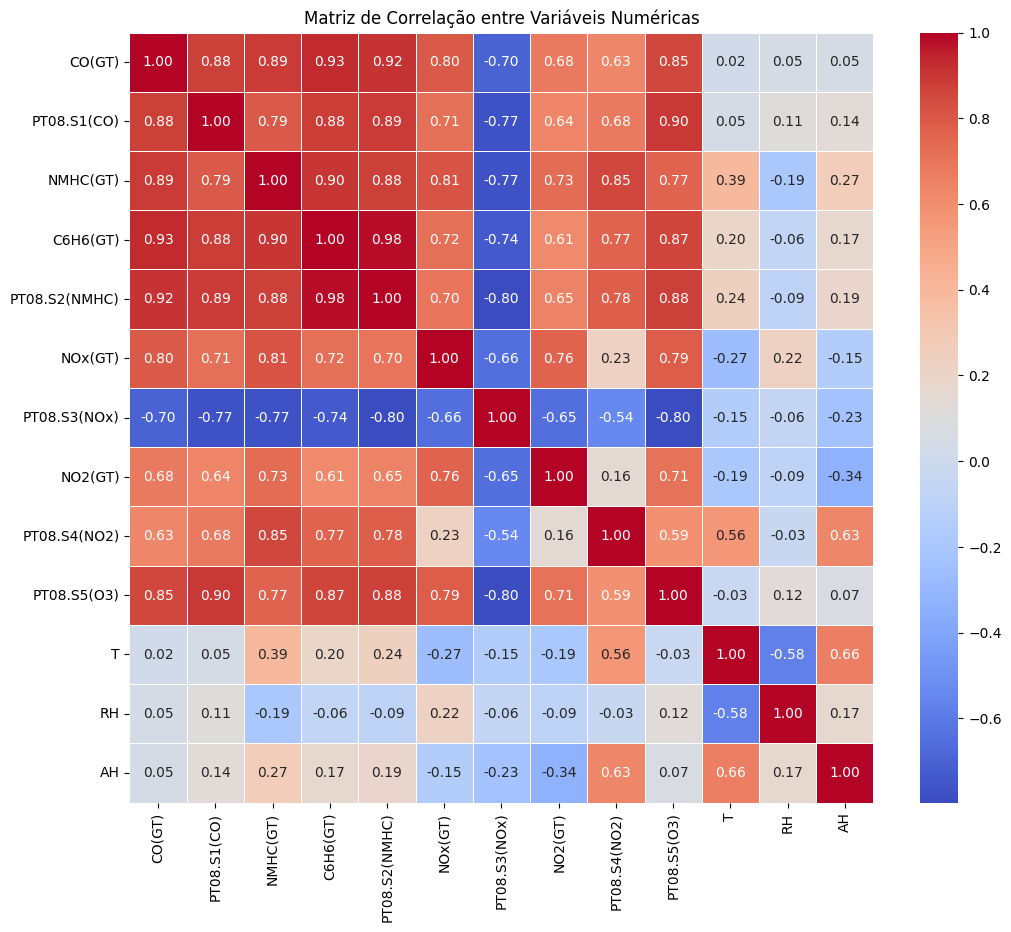

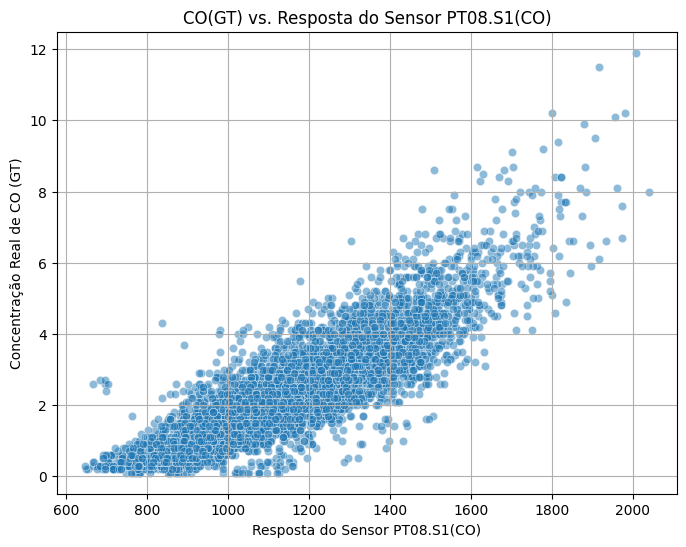

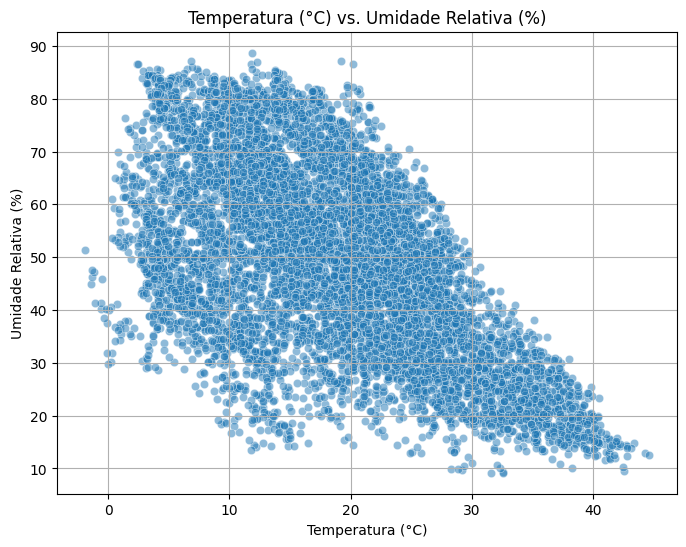

In [9]:
# Matriz de Correlação
# Selecionar apenas colunas numéricas para a matriz de correlação
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação entre Variáveis Numéricas')
plt.show()

# Scatter plots entre algumas variáveis de interesse
# Por exemplo, CO(GT) vs PT08.S1(CO) (sensor de CO)
# T vs RH (Temperatura vs Umidade Relativa)

if 'CO(GT)' in df.columns and 'PT08.S1(CO)' in df.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='PT08.S1(CO)', y='CO(GT)', data=df, alpha=0.5)
    plt.title('CO(GT) vs. Resposta do Sensor PT08.S1(CO)')
    plt.xlabel('Resposta do Sensor PT08.S1(CO)')
    plt.ylabel('Concentração Real de CO (GT)')
    plt.grid(True)
    plt.show()

if 'T' in df.columns and 'RH' in df.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='T', y='RH', data=df, alpha=0.5)
    plt.title('Temperatura (°C) vs. Umidade Relativa (%)')
    plt.xlabel('Temperatura (°C)')
    plt.ylabel('Umidade Relativa (%)')
    plt.grid(True)
    plt.show()

## **Observações da Análise Bivariada:**
* **Correlações**: A matriz de correlação destacará relações lineares fortes entre as variáveis. Espera-se correlação entre os sensores e as medições de referência (GT - Ground Truth), e também entre diferentes sensores que podem ser sensíveis a compostos similares ou afetados pelas mesmas condições ambientais.
* **Temperatura e Umidade**: Geralmente há uma correlação negativa entre temperatura e umidade relativa.
* **Sensores**: Os sensores (PT08.Sx) devem mostrar correlação com as concentrações reais dos poluentes que eles se destinam a medir.

4. Análise de Séries Temporais

---


Como os dados são coletados ao longo do tempo, visualizar as séries temporais é crucial.

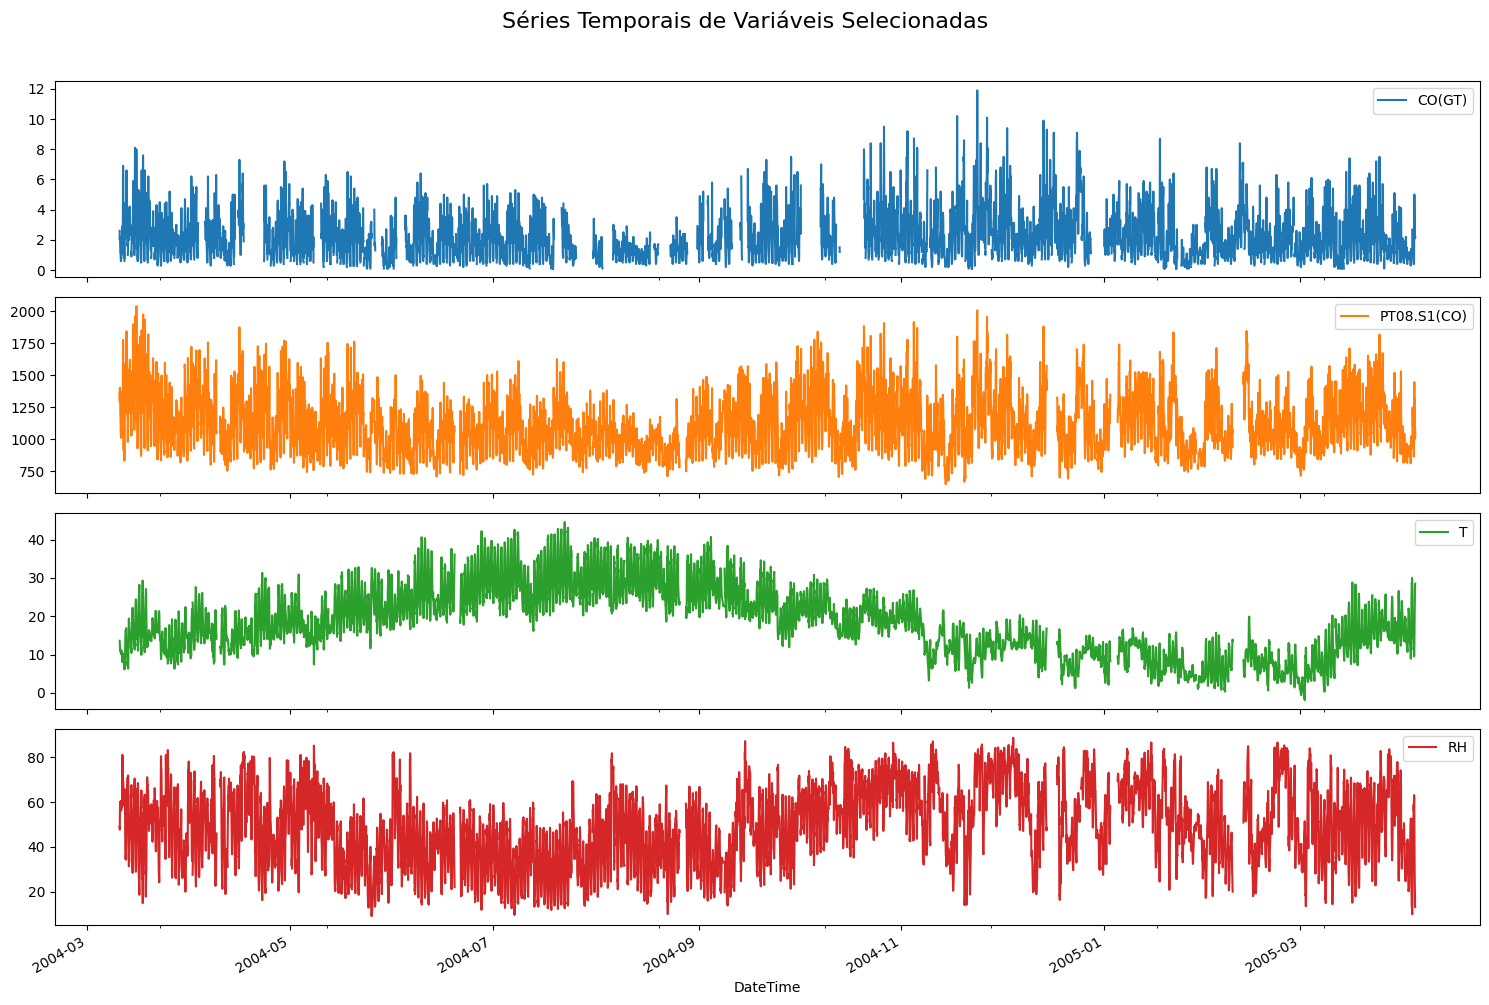

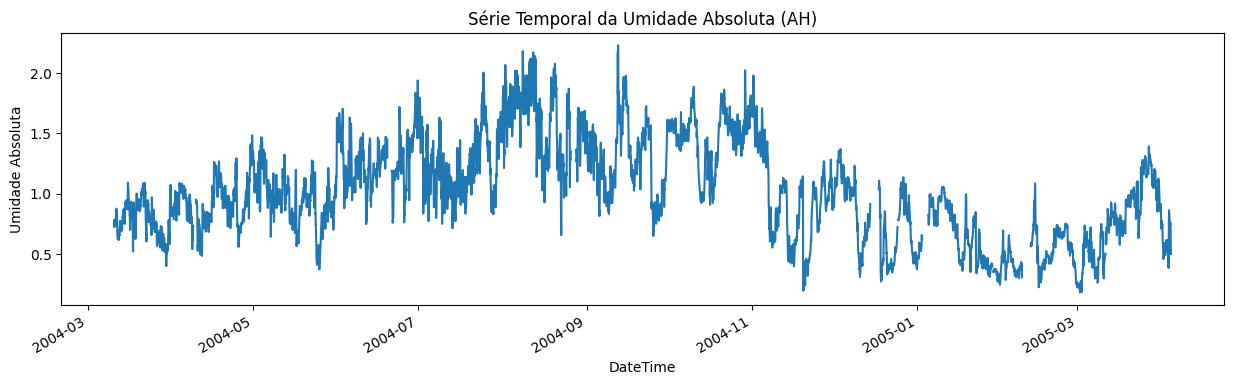

In [10]:
# Plotar algumas séries temporais
# Verificar se o índice é DateTime antes de plotar
if isinstance(df.index, pd.DatetimeIndex):
    cols_to_plot_ts = ['CO(GT)', 'PT08.S1(CO)', 'T', 'RH']
    # Filtrar colunas que realmente existem no DataFrame
    cols_to_plot_ts = [col for col in cols_to_plot_ts if col in df.columns]

    if cols_to_plot_ts:
        df[cols_to_plot_ts].plot(subplots=True, figsize=(15, 10), layout=(-1, 1))
        plt.suptitle('Séries Temporais de Variáveis Selecionadas', y=1.00, size=16)
        plt.tight_layout(rect=[0, 0, 1, 0.98]) # Ajustar layout para não sobrepor o suptitle
        plt.show()

        # Plotar a umidade absoluta se disponível
        if 'AH' in df.columns:
            df['AH'].plot(figsize=(15, 4))
            plt.title('Série Temporal da Umidade Absoluta (AH)')
            plt.ylabel('Umidade Absoluta')
            plt.show()
    else:
        print("\nNenhuma das colunas selecionadas para plotagem de séries temporais está presente no DataFrame.")
else:
    print("\nO índice não é do tipo DateTime. A plotagem de séries temporais pode não ser ideal.")

## Observações da Análise de Séries Temporais:

* Tendências: É possível observar tendências de longo prazo nas concentrações de poluentes ou nas variáveis meteorológicas.
* Sazonalidade: Pode haver padrões sazonais (e.g., concentrações de certos poluentes mais altas no inverno).
Padrões Diários: Muitos poluentes exibem ciclos diários devido ao tráfego e atividades industriais.
* Anomalias/Eventos: Picos ou quedas repentinas podem indicar eventos específicos ou problemas nos sensores.
* Lacunas: As séries temporais também tornarão visualmente claras as lacunas devido aos dados faltantes.

# Tratamento de Dados Faltantes



--- ANÁLISE DE DADOS FALTANTES ---
               Count  Percentage
NMHC(GT)        8412   90.199442
CO(GT)          1652   17.713918
NO2(GT)         1611   17.274287
NOx(GT)         1608   17.242119
PT08.S1(CO)      335    3.592108
PT08.S2(NMHC)    335    3.592108
C6H6(GT)         335    3.592108
PT08.S3(NOx)     335    3.592108
PT08.S4(NO2)     335    3.592108
PT08.S5(O3)      335    3.592108
T                335    3.592108
RH               335    3.592108
AH               335    3.592108


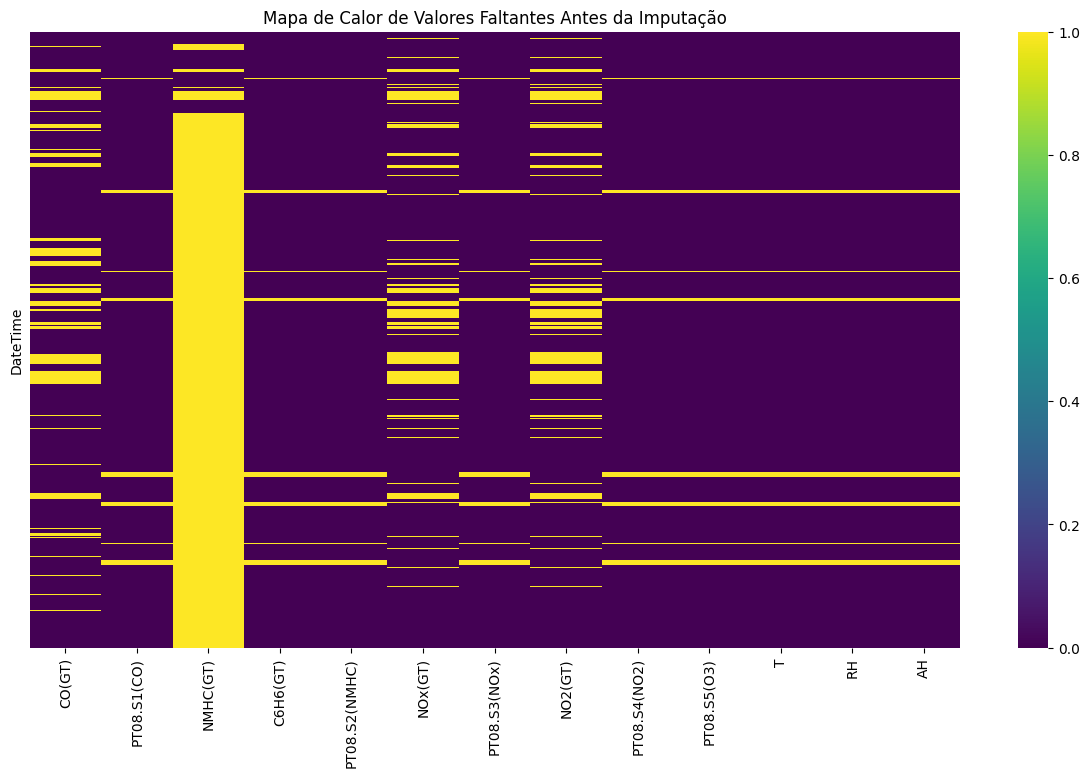

In [11]:
# 1. ANÁLISE DE DADOS FALTANTES DETALHADA
print("\n--- ANÁLISE DE DADOS FALTANTES ---")
missing_values_count = df.isnull().sum()
total_rows = len(df)
missing_values_percentage = (missing_values_count / total_rows) * 100
missing_df = pd.DataFrame({
    'Count': missing_values_count,
    'Percentage': missing_values_percentage
}).sort_values(by='Percentage', ascending=False)
print(missing_df[missing_df['Count'] > 0])

plt.figure(figsize=(15, 8))
sns.heatmap(df.isnull(), cbar=True, cmap='viridis', yticklabels=False)
plt.title('Mapa de Calor de Valores Faltantes Antes da Imputação')
plt.show()

**Remoção da Coluna NMHC(GT) (Condicional):**

Técnica: Excluir a coluna inteira.
Porquê: Se a proporção de dados faltantes for excessivamente alta (e.g., >85-90%), a imputação pode introduzir mais ruído e viés do que informação útil. Remover a coluna é muitas vezes a abordagem mais segura e simples nessas circunstâncias para evitar a distorção da análise ou do modelo subsequente.

In [12]:
# 2. DECISÃO SOBRE NMHC(GT)
# Esta coluna é conhecida por ter muitos dados faltantes.
# Se a porcentagem for muito alta (ex: > 85%), remover.
if 'NMHC(GT)' in df.columns and (df['NMHC(GT)'].isnull().sum() / len(df) * 100) > 85:
    print(f"\nRemovendo a coluna 'NMHC(GT)' devido a {missing_values_percentage.get('NMHC(GT)', 0):.2f}% de valores faltantes.")
    df.drop('NMHC(GT)', axis=1, inplace=True)
    numeric_cols = [col for col in numeric_cols if col != 'NMHC(GT)'] # Atualizar lista de colunas numéricas
else:
    print("\nColuna 'NMHC(GT)' mantida (ou não existe).")



Removendo a coluna 'NMHC(GT)' devido a 90.20% de valores faltantes.



--- ANÁLISE UNIVARIADA ---


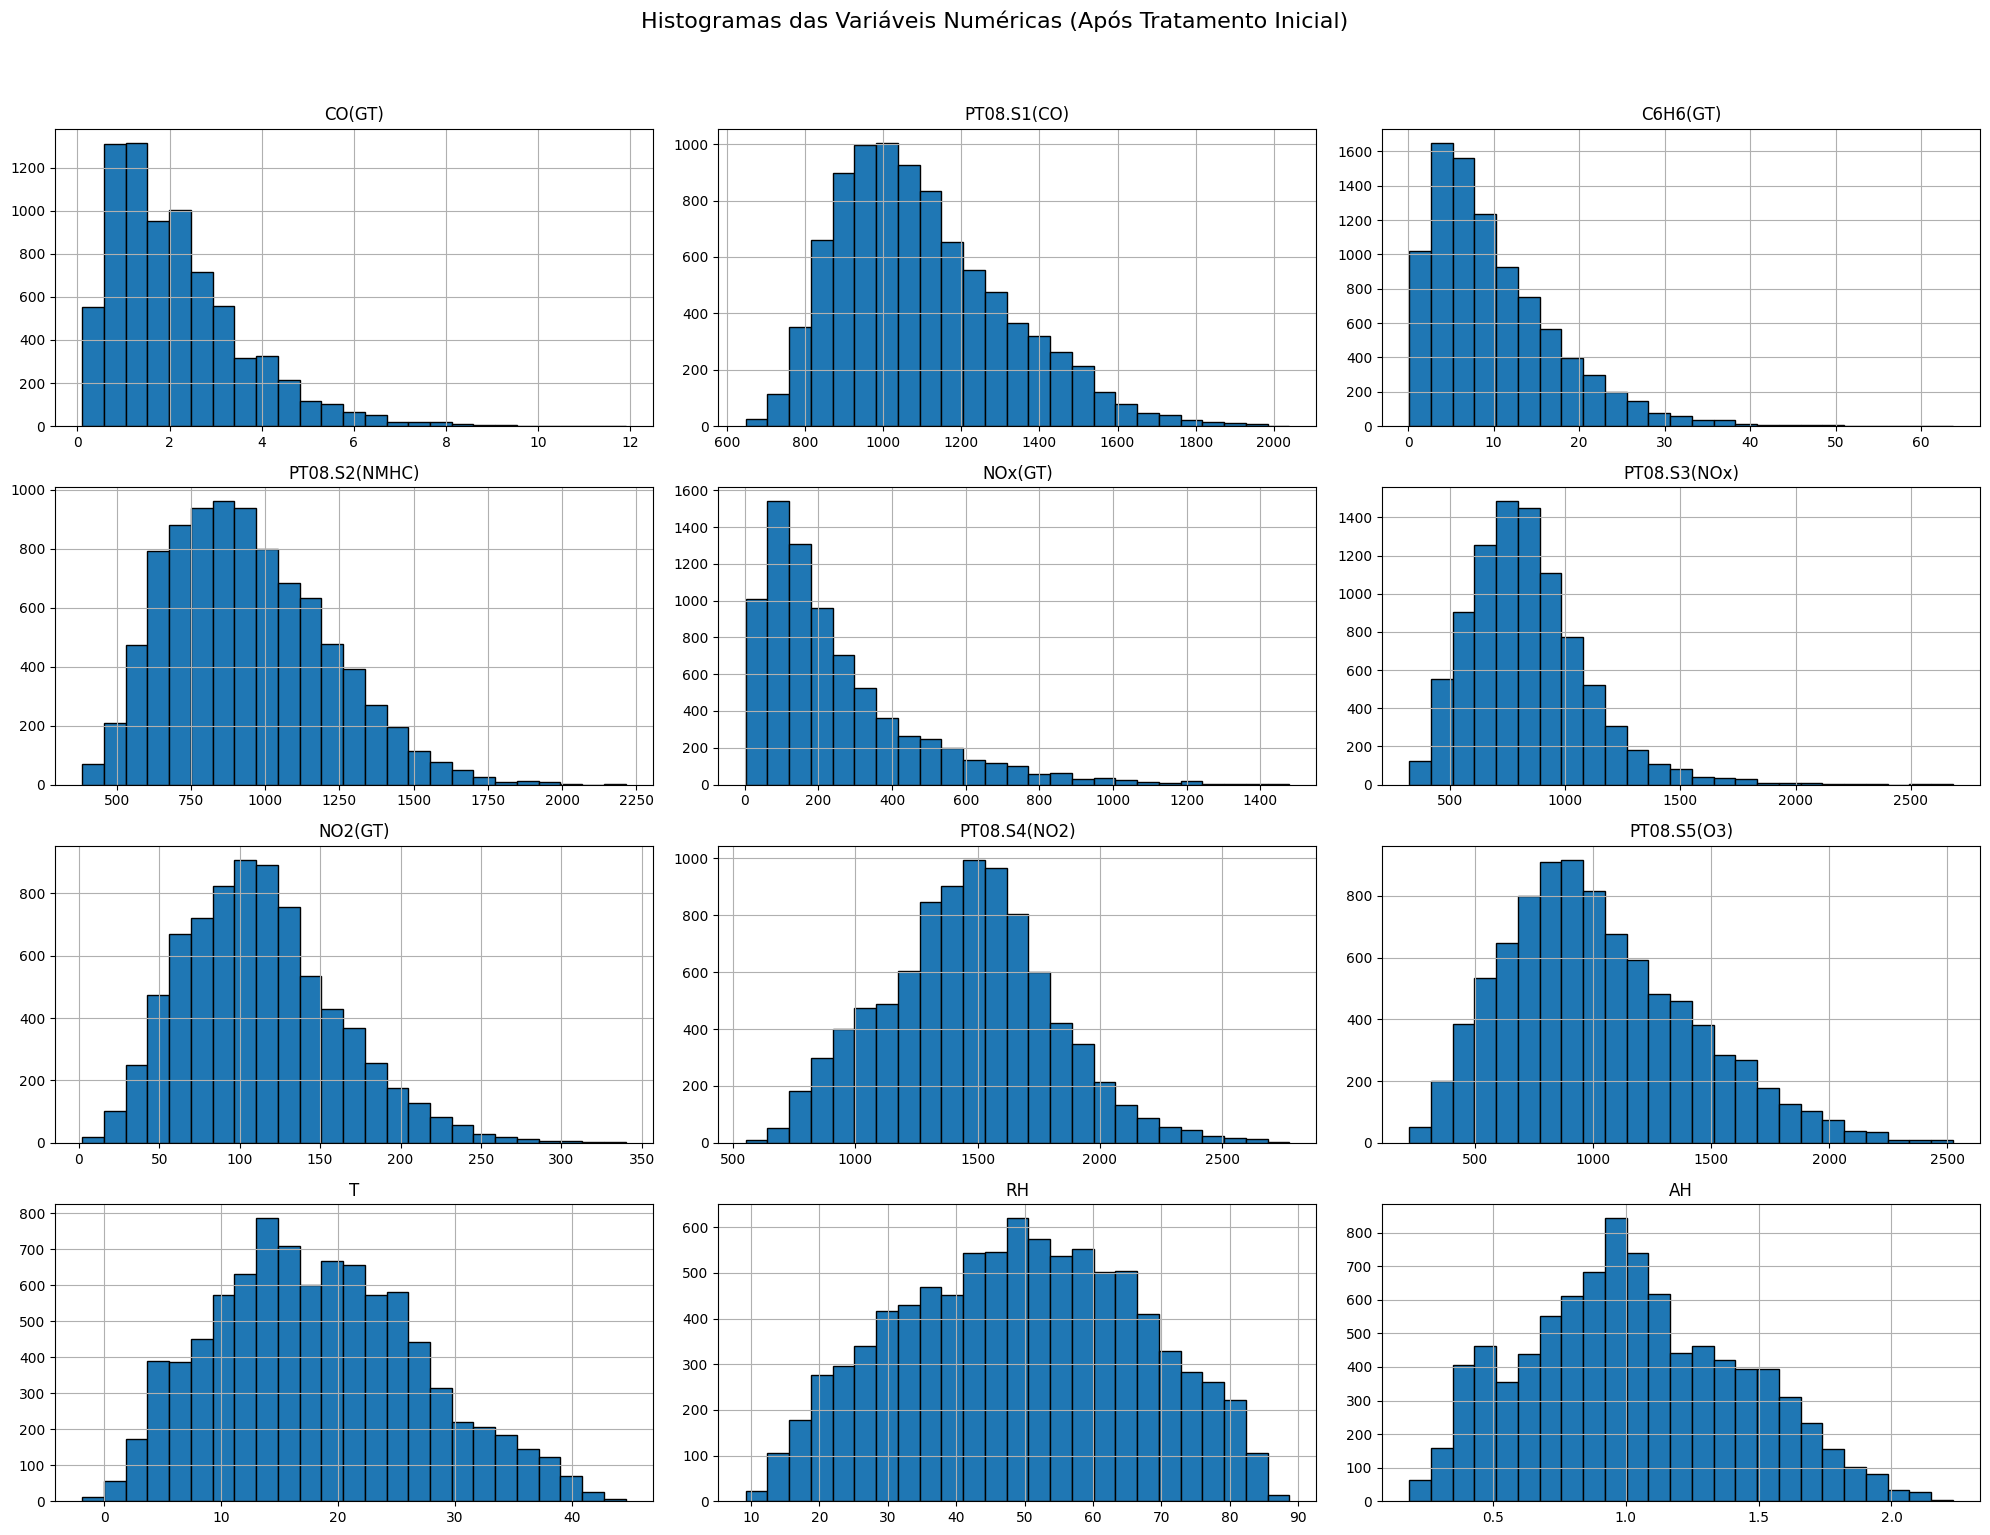

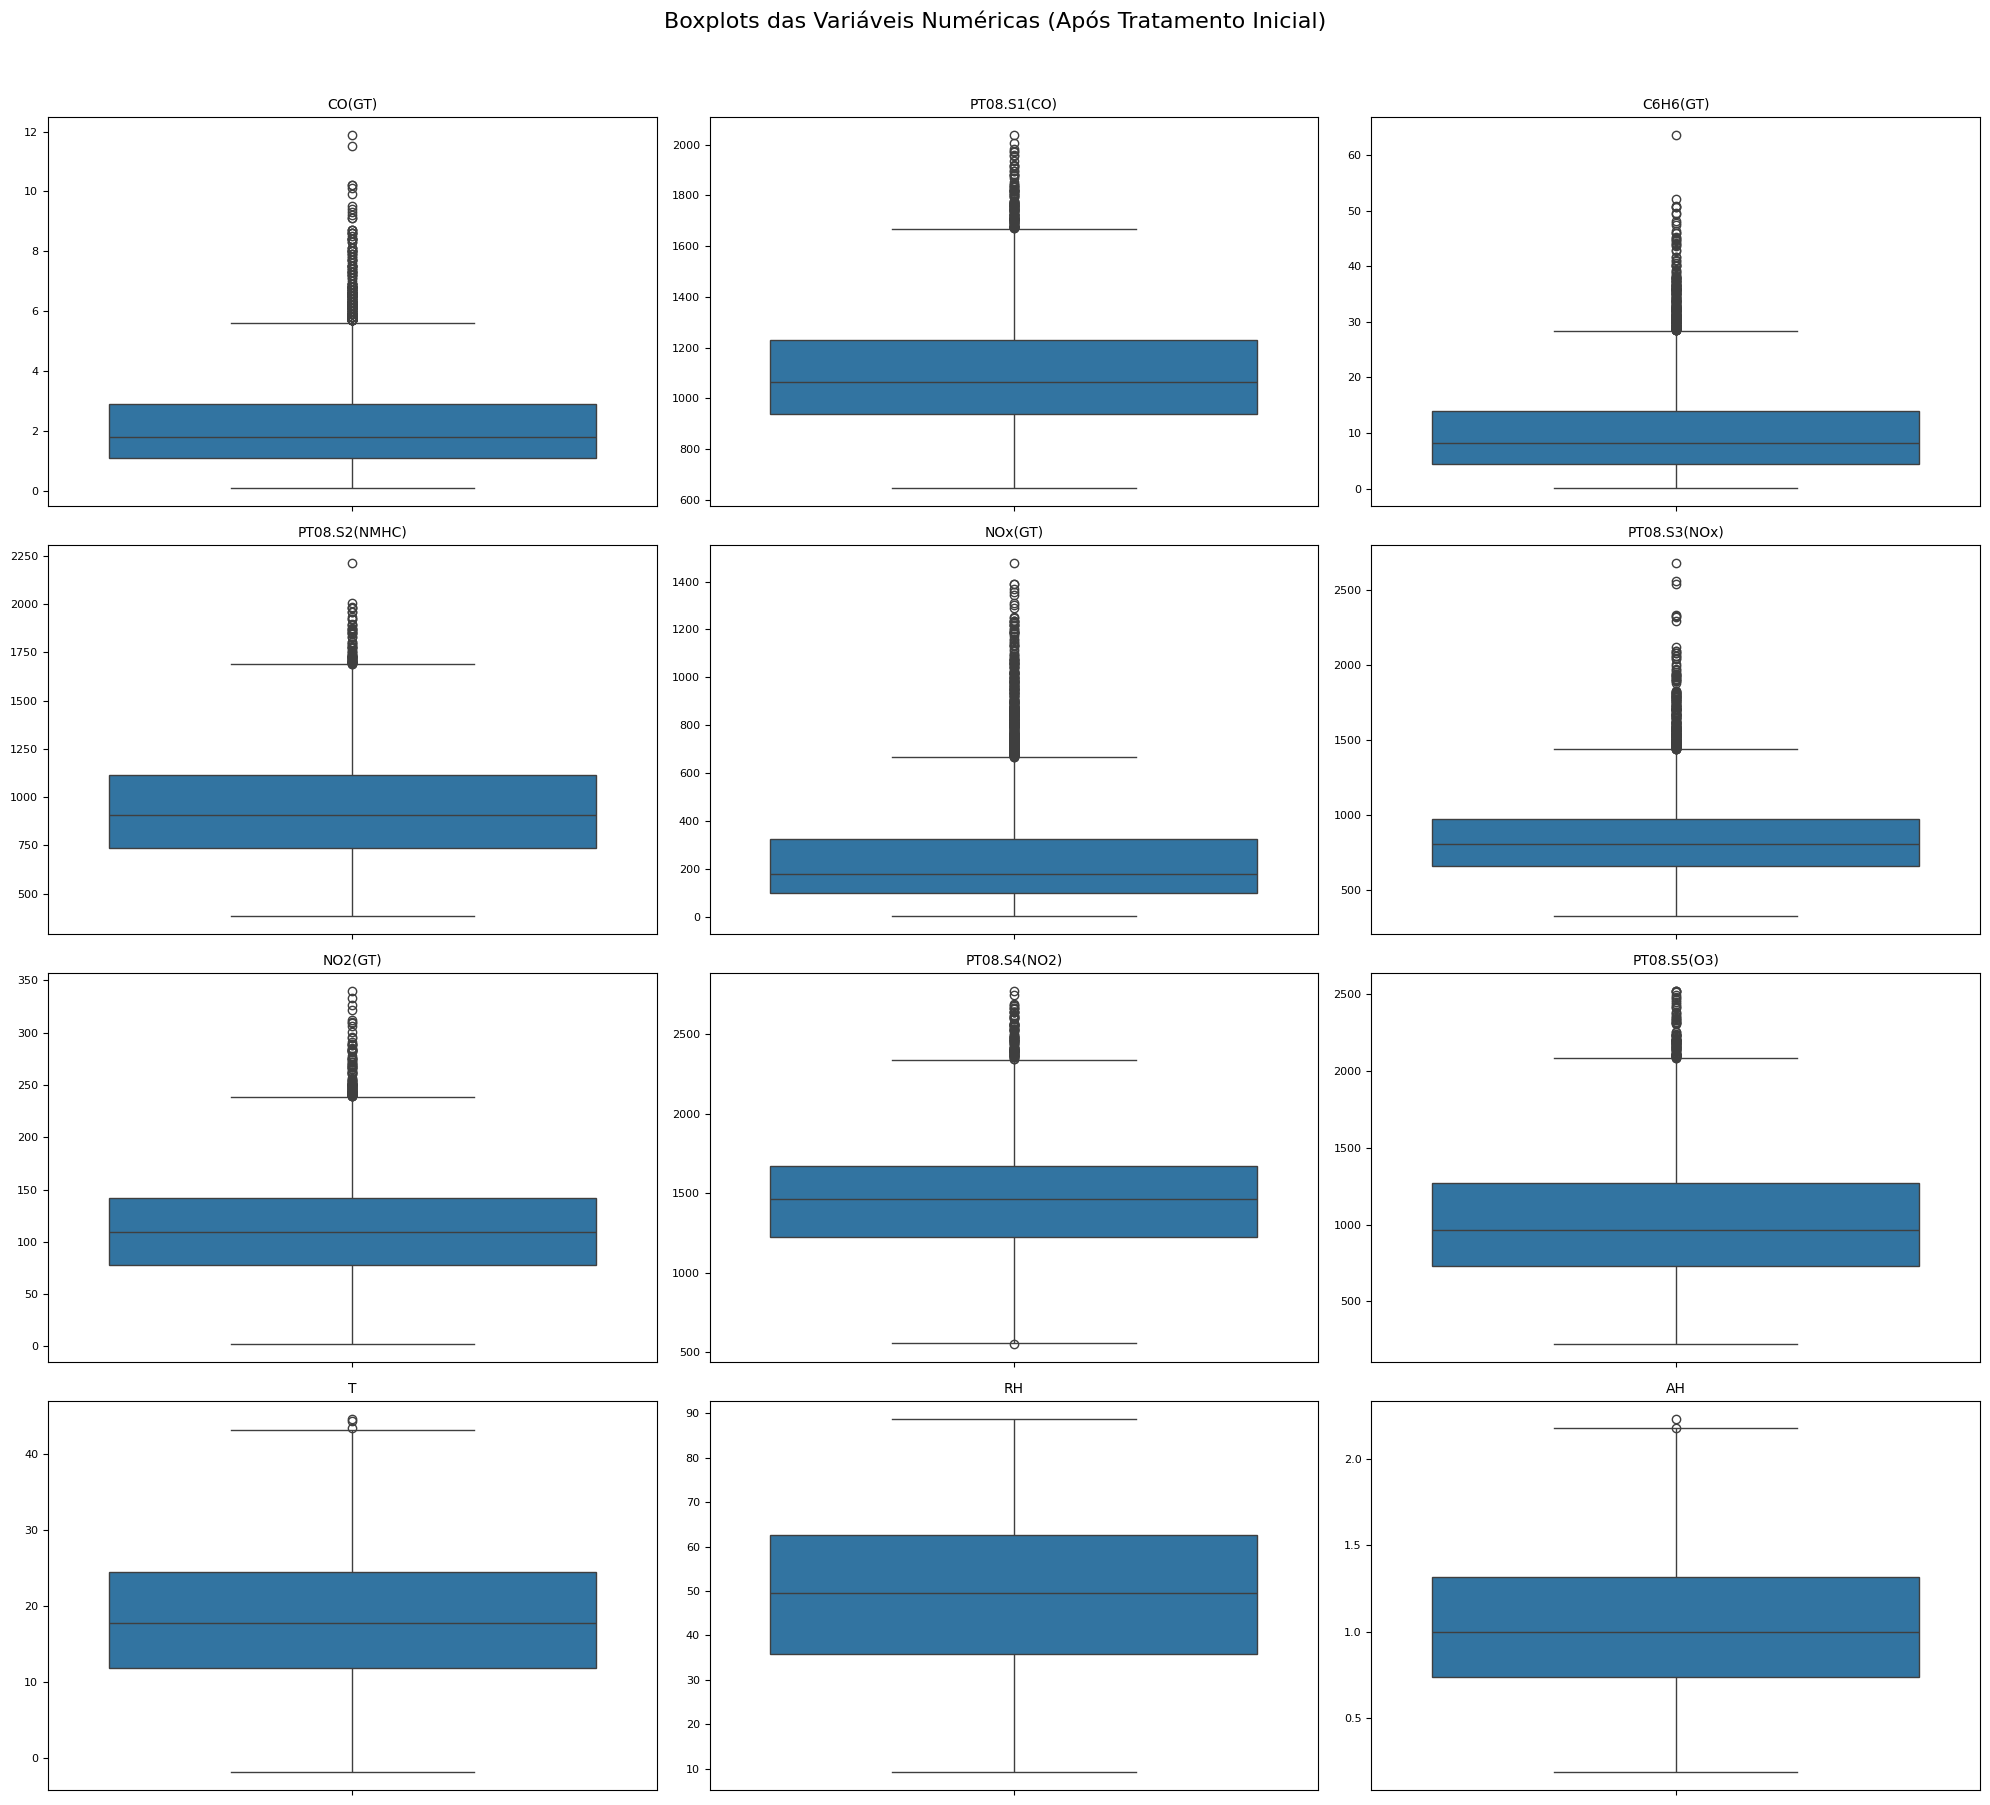

In [13]:
# 3. ANÁLISE UNIVARIADA (Histogramas e Boxplots)
print("\n--- ANÁLISE UNIVARIADA ---")
# Atualizar numeric_cols caso NMHC(GT) tenha sido removida
current_numeric_cols = df.select_dtypes(include=np.number).columns

df[current_numeric_cols].hist(bins=25, figsize=(20, 15), layout=(-1, 3), edgecolor='black')
plt.suptitle('Histogramas das Variáveis Numéricas (Após Tratamento Inicial)', y=1.02, size=16)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

plt.figure(figsize=(20, 18)) # Aumentar altura para mais subplots
num_cols = len(current_numeric_cols)
num_plot_cols = 3
num_plot_rows = (num_cols + num_plot_cols - 1) // num_plot_cols # Calcular linhas necessárias

for i, col in enumerate(current_numeric_cols):
    plt.subplot(num_plot_rows, num_plot_cols, i + 1)
    sns.boxplot(y=df[col])
    plt.title(col, fontsize=10)
    plt.ylabel('')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
plt.suptitle('Boxplots das Variáveis Numéricas (Após Tratamento Inicial)', y=1.00, size=16) # Ajustar y
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Ajustar para suptitle
plt.show()


--- ANÁLISE BIVARIADA ---


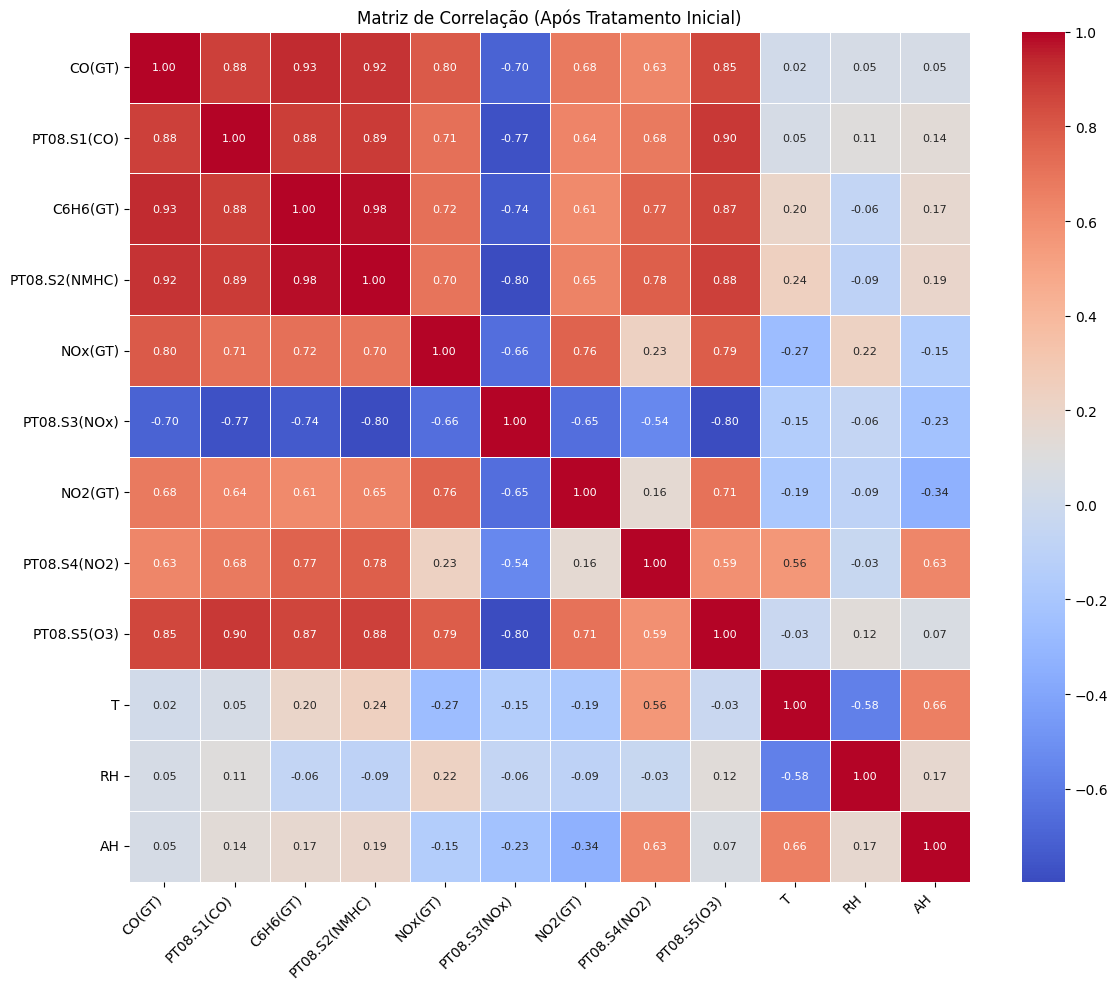

In [14]:
# 4. ANÁLISE BIVARIADA (Matriz de Correlação)
print("\n--- ANÁLISE BIVARIADA ---")
if not df[current_numeric_cols].empty:
    correlation_matrix = df[current_numeric_cols].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
    plt.title('Matriz de Correlação (Após Tratamento Inicial)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("Não há colunas numéricas suficientes para a matriz de correlação.")



--- ANÁLISE DE SÉRIES TEMPORAIS ---


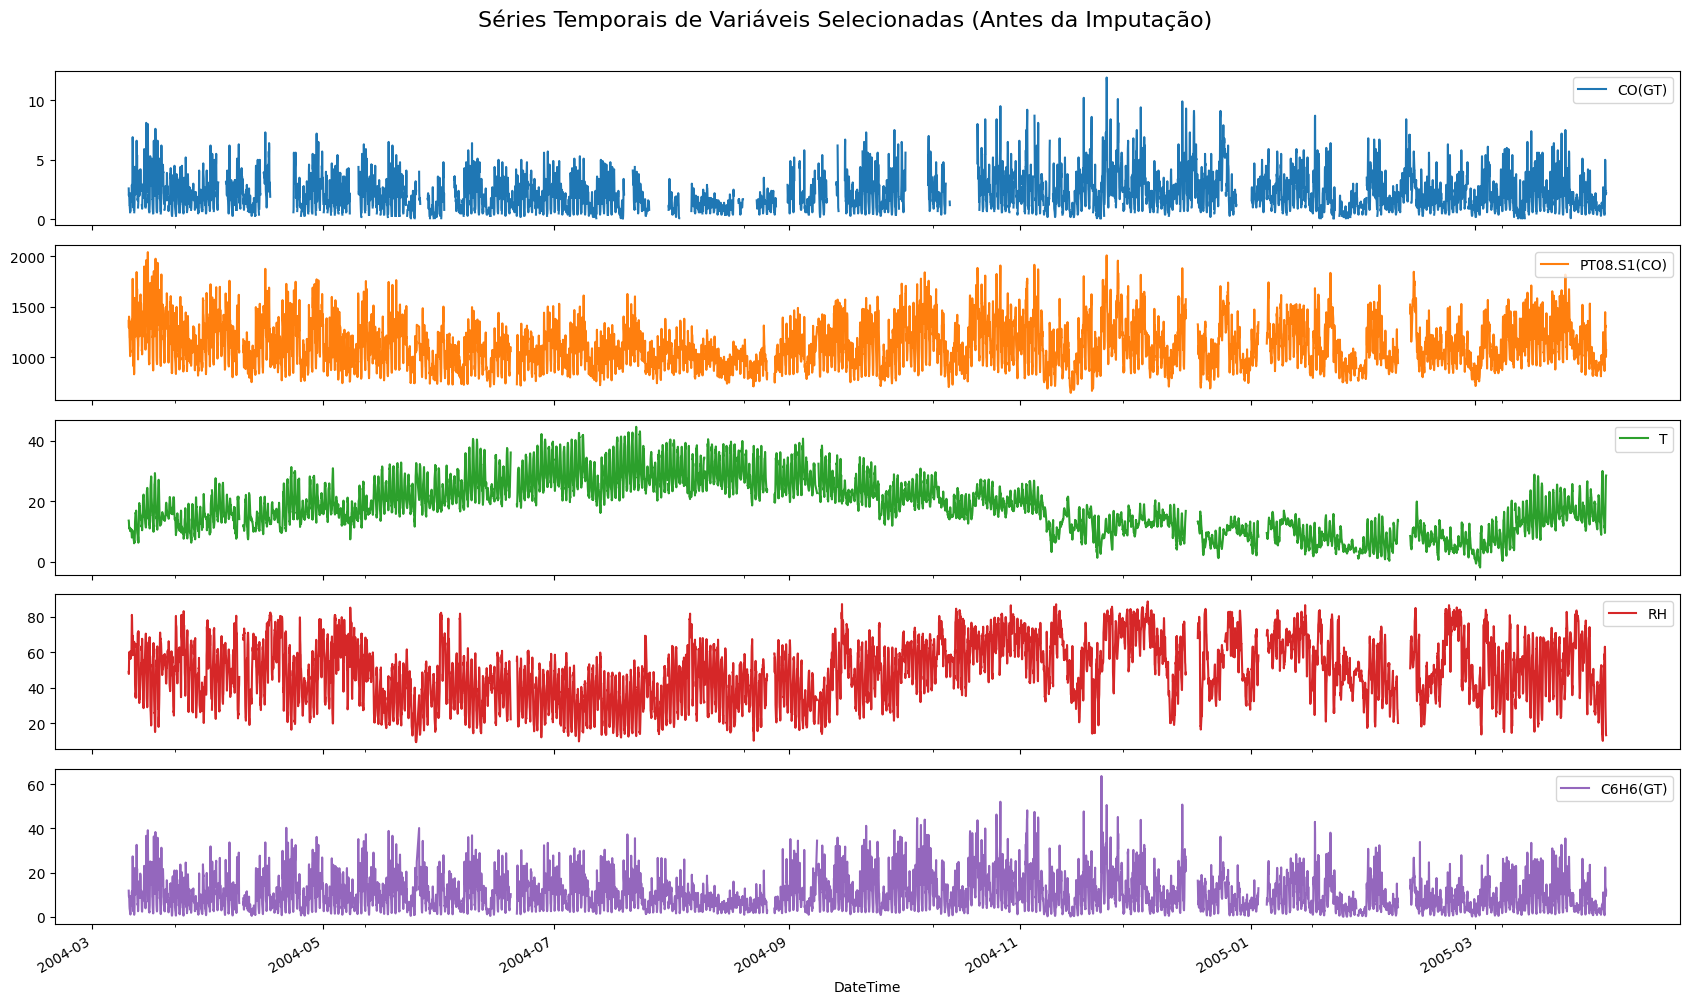

In [15]:
# 5. ANÁLISE DE SÉRIES TEMPORAIS
print("\n--- ANÁLISE DE SÉRIES TEMPORAIS ---")
if isinstance(df.index, pd.DatetimeIndex):
    cols_to_plot_ts = ['CO(GT)', 'PT08.S1(CO)', 'T', 'RH', 'C6H6(GT)']
    cols_to_plot_ts = [col for col in cols_to_plot_ts if col in df.columns and df[col].notnull().any()]

    if cols_to_plot_ts:
        df[cols_to_plot_ts].plot(subplots=True, figsize=(17, 2*len(cols_to_plot_ts)), layout=(-1, 1), sharex=True)
        plt.suptitle('Séries Temporais de Variáveis Selecionadas (Antes da Imputação)', y=1.00, size=16)
        plt.tight_layout(rect=[0, 0, 1, 0.99])
        plt.show()
    else:
        print("Nenhuma das colunas selecionadas para plotagem de séries temporais está presente ou possui dados.")
else:
    print("Índice não é DateTime, pulando plotagem de séries temporais detalhada.")



## **Interpolação** Linear (Principal Técnica de Imputação):

* Técnica: Preencher valores faltantes estimando-os com base nos valores vizinhos conhecidos, assumindo uma relação linear entre eles. O parâmetro limit_direction='both' ajuda a preencher lacunas no início e no fim, se possível.

* Porquê:
 * **Natureza Temporal dos Dados:** Os dados de qualidade do ar são séries temporais, onde as medições em momentos próximos tendem a ser correlacionadas. A temperatura, umidade e concentrações de poluentes geralmente não mudam drasticamente de uma hora para a outra em condições normais.
 * **Preservação de Tendências:** A interpolação ajuda a manter a tendência local dos dados, o que é preferível a simplesmente preencher com uma média ou mediana global que ignoraria a dinâmica temporal.
 * **Simplicidade e Eficiência:** É computacionalmente eficiente e fácil de implementar com bibliotecas como o Pandas.
 * **Adequado para Lacunas Curtas a Médias:** Funciona bem quando as lacunas de dados não são excessivamente longas.

In [16]:
# --- ESTRATÉGIA DE IMPUTAÇÃO PROPOSTA ---
print("\n--- TRATAMENTO DE DADOS FALTANTES ---")
df_imputed = df.copy()

# Estratégia: Interpolação linear para todas as colunas numéricas.
# É boa para séries temporais e geralmente lida bem com a maioria dos dados neste dataset.
print("\nAplicando Interpolação Linear...")
for col in df_imputed.select_dtypes(include=np.number).columns:
    if df_imputed[col].isnull().any():
        print(f"Interpolando coluna: {col}")
        df_imputed[col].interpolate(method='linear', limit_direction='both', inplace=True)


--- TRATAMENTO DE DADOS FALTANTES ---

Aplicando Interpolação Linear...
Interpolando coluna: CO(GT)
Interpolando coluna: PT08.S1(CO)
Interpolando coluna: C6H6(GT)
Interpolando coluna: PT08.S2(NMHC)
Interpolando coluna: NOx(GT)
Interpolando coluna: PT08.S3(NOx)
Interpolando coluna: NO2(GT)
Interpolando coluna: PT08.S4(NO2)
Interpolando coluna: PT08.S5(O3)
Interpolando coluna: T
Interpolando coluna: RH
Interpolando coluna: AH


C:\Users\Roger\AppData\Local\Temp\ipykernel_22632\397209569.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputed[col].interpolate(method='linear', limit_direction='both', inplace=True)


In [17]:
# Verificar se ainda há faltantes (geralmente não após 'limit_direction'='both',
# a menos que uma coluna inteira seja NaN, o que não deve ocorrer após o dropna inicial)
remaining_missing = df_imputed.isnull().sum()
print("\nValores faltantes após interpolação linear:")
print(remaining_missing[remaining_missing > 0])

if remaining_missing.sum() > 0:
    print("\nValores faltantes ainda presentes. Aplicando ffill e bfill como último recurso.")
    df_imputed.ffill(inplace=True)
    df_imputed.bfill(inplace=True)
    print("\nValores faltantes após ffill/bfill:")
    print(df_imputed.isnull().sum()[df_imputed.isnull().sum() > 0])


# Verificar o resultado
print("\nPrimeiras linhas do DataFrame imputado:")
print(df_imputed.head())
print("\nInformações do DataFrame imputado:")
df_imputed.info()


Valores faltantes após interpolação linear:
Series([], dtype: int64)

Primeiras linhas do DataFrame imputado:
                     CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
DateTime                                                                     
2004-03-10 18:00:00     2.6       1360.0      11.9         1046.0    166.0   
2004-03-10 19:00:00     2.0       1292.0       9.4          955.0    103.0   
2004-03-10 20:00:00     2.2       1402.0       9.0          939.0    131.0   
2004-03-10 21:00:00     2.2       1376.0       9.2          948.0    172.0   
2004-03-10 22:00:00     1.6       1272.0       6.5          836.0    131.0   

                     PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T  \
DateTime                                                                      
2004-03-10 18:00:00        1056.0    113.0        1692.0       1268.0  13.6   
2004-03-10 19:00:00        1174.0     92.0        1559.0        972.0  13.3   
2004-03-10 20:00:00       

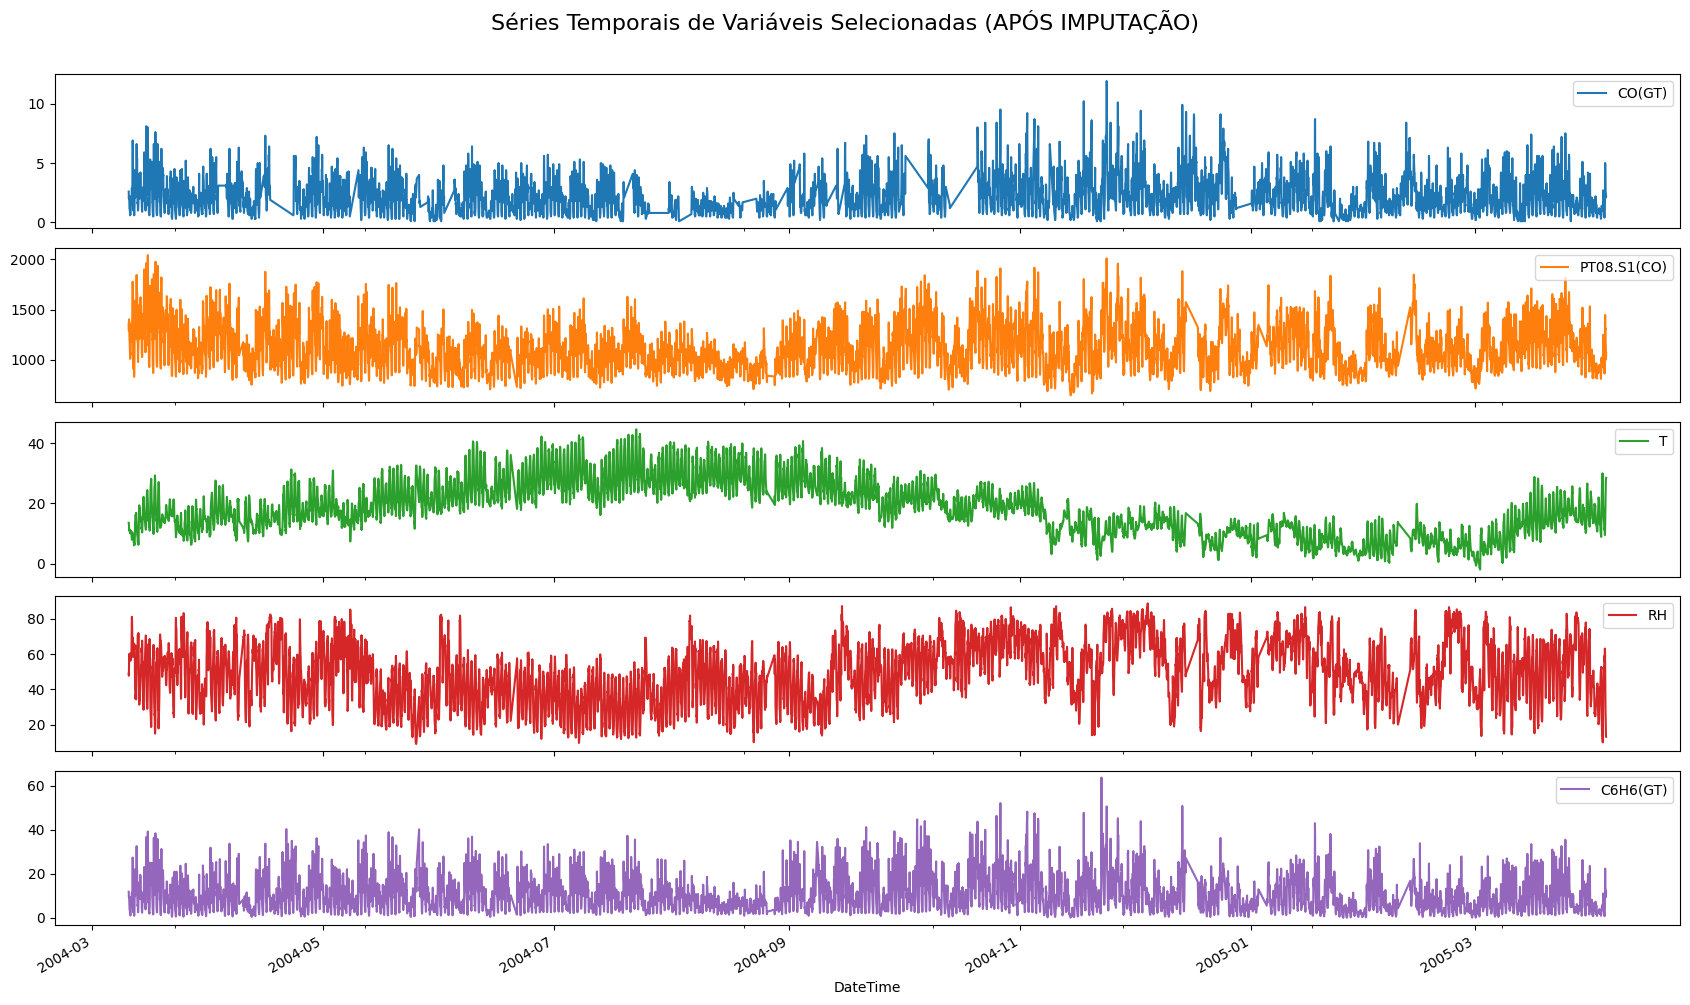

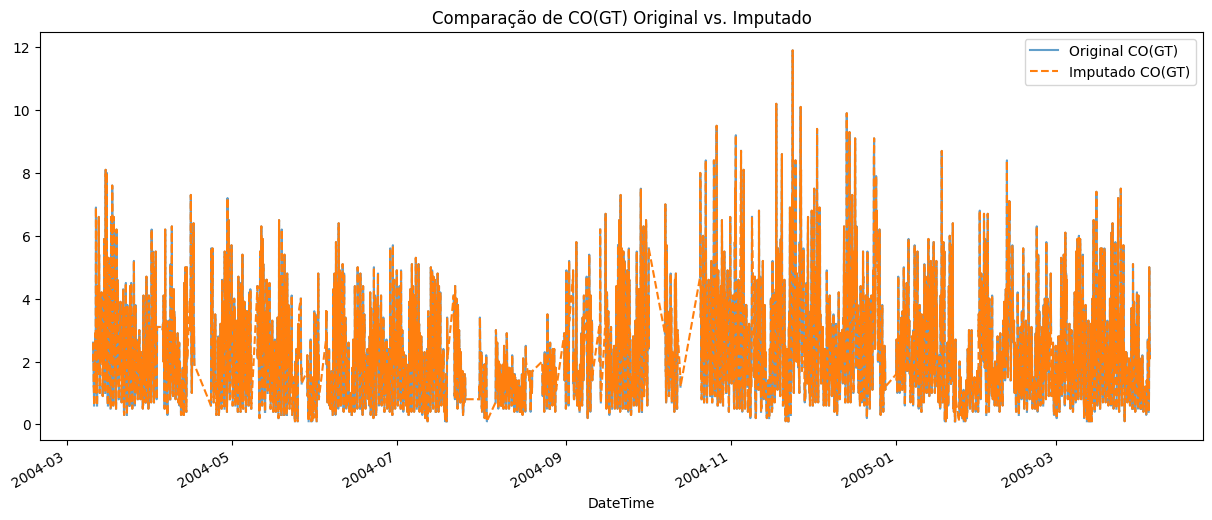


EDA e sugestão de tratamento de dados faltantes concluídos.


In [18]:
# Visualizar séries temporais após imputação
if isinstance(df_imputed.index, pd.DatetimeIndex) and cols_to_plot_ts:
    df_imputed[cols_to_plot_ts].plot(subplots=True, figsize=(17, 2*len(cols_to_plot_ts)), layout=(-1, 1), sharex=True)
    plt.suptitle('Séries Temporais de Variáveis Selecionadas (APÓS IMPUTAÇÃO)', y=1.00, size=16)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()

    # Comparar uma variável antes e depois da imputação
    if 'CO(GT)' in df.columns and 'CO(GT)' in df_imputed.columns: # Verificar se CO(GT) existe
        plt.figure(figsize=(15, 6))
        df['CO(GT)'].plot(label='Original CO(GT)', alpha=0.7)
        df_imputed['CO(GT)'].plot(label='Imputado CO(GT)', linestyle='--')
        plt.title('Comparação de CO(GT) Original vs. Imputado')
        plt.legend()
        plt.show()
else:
    print("Não foi possível plotar séries temporais imputadas (índice não é DateTime ou colunas não disponíveis).")

print("\nEDA e sugestão de tratamento de dados faltantes concluídos.")

In [19]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler # Usaremos StandardScaler para escalonamento
from sklearn.impute import KNNImputer
# --- TRATAMENTO DE DADOS FALTANTES COM KNNIMPUTER ---
print("\n--- TRATAMENTO DE DADOS FALTANTES COM KNNIMPUTER ---")

df_imputed_knn = df.copy()
# Selecionar apenas colunas numéricas para imputação
numeric_cols_for_imputation = df_imputed_knn.select_dtypes(include=np.number).columns

if df_imputed_knn.empty or numeric_cols_for_imputation.empty:
    print("DataFrame vazio ou sem colunas numéricas para imputação.")
elif not df_imputed_knn[numeric_cols_for_imputation].isnull().values.any():
    print("Não há dados faltantes nas colunas numéricas para imputar com KNNImputer.")
else:
    print("Valores faltantes encontrados. Prosseguindo com KNN Imputation.")

    # Salvar o índice e nomes de colunas numéricas para reconstrução
    original_index = df_imputed_knn.index
    original_numeric_columns = numeric_cols_for_imputation.tolist()

    # 1. Escalonamento dos dados numéricos
    scaler = StandardScaler()
    # Certifique-se de que estamos trabalhando com uma cópia para evitar SettingWithCopyWarning
    df_numeric_scaled = df_imputed_knn[original_numeric_columns].copy()
    df_numeric_scaled.iloc[:,:] = scaler.fit_transform(df_numeric_scaled)


    # 2. Aplicação do KNNImputer
    k_neighbors = 5 # Um valor comum para k
    print(f"\nAplicando KNNImputer com k={k_neighbors}...")
    imputer_knn = KNNImputer(n_neighbors=k_neighbors)

    # O imputer retorna um array numpy
    imputed_scaled_values = imputer_knn.fit_transform(df_numeric_scaled)

    # 3. Reversão da Escala
    imputed_values_original_scale = scaler.inverse_transform(imputed_scaled_values)

    # 4. Reconstruir o DataFrame com os dados numéricos imputados
    df_temp_imputed_numeric = pd.DataFrame(imputed_values_original_scale, columns=original_numeric_columns, index=original_index)

    # Juntar de volta com colunas não numéricas (se houver)
    df_non_numeric = df_imputed_knn.select_dtypes(exclude=np.number)
    if not df_non_numeric.empty:
        df_imputed_knn = pd.concat([df_non_numeric, df_temp_imputed_numeric], axis=1)
    else:
        df_imputed_knn = df_temp_imputed_numeric

    # Reordenar colunas para a ordem original do DataFrame original 'df', se necessário
    # (considerando que 'NMHC(GT)' pode ter sido removida)
    final_columns_order = [col for col in df.columns if col in df_imputed_knn.columns]
    df_imputed_knn = df_imputed_knn[final_columns_order]


    print("\nValores faltantes após KNN Imputation:")
    remaining_missing_knn = df_imputed_knn.isnull().sum()
    print(remaining_missing_knn[remaining_missing_knn > 0])

    if remaining_missing_knn.sum() == 0:
        print("Nenhum valor faltante restante após KNN Imputation.")
    else:
        print("ATENÇÃO: Valores faltantes ainda presentes após KNN Imputation.")
        print("Isso pode ocorrer se todas as features de um vizinho também forem NaN para uma dada amostra,")
        print("ou se houver linhas/colunas inteiras de NaNs que o scaler/imputer não conseguiu processar.")
        print("Aplicando ffill e bfill como último recurso para os faltantes restantes...")
        df_imputed_knn.ffill(inplace=True)
        df_imputed_knn.bfill(inplace=True)
        final_check_missing = df_imputed_knn.isnull().sum()
        print("\nValores faltantes após ffill/bfill de último recurso:")
        print(final_check_missing[final_check_missing > 0])
        if final_check_missing.sum() == 0:
            print("Todos os valores faltantes foram tratados.")


--- TRATAMENTO DE DADOS FALTANTES COM KNNIMPUTER ---
Valores faltantes encontrados. Prosseguindo com KNN Imputation.

Aplicando KNNImputer com k=5...

Valores faltantes após KNN Imputation:
Series([], dtype: int64)
Nenhum valor faltante restante após KNN Imputation.



--- ANÁLISE PÓS-IMPUTAÇÃO (KNN) ---

Primeiras linhas do DataFrame imputado com KNN:
                     CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
DateTime                                                                     
2004-03-10 18:00:00     2.6       1360.0      11.9         1046.0    166.0   
2004-03-10 19:00:00     2.0       1292.0       9.4          955.0    103.0   
2004-03-10 20:00:00     2.2       1402.0       9.0          939.0    131.0   
2004-03-10 21:00:00     2.2       1376.0       9.2          948.0    172.0   
2004-03-10 22:00:00     1.6       1272.0       6.5          836.0    131.0   

                     PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T  \
DateTime                                                                      
2004-03-10 18:00:00        1056.0    113.0        1692.0       1268.0  13.6   
2004-03-10 19:00:00        1174.0     92.0        1559.0        972.0  13.3   
2004-03-10 20:00:00        1140.0    114.0        1

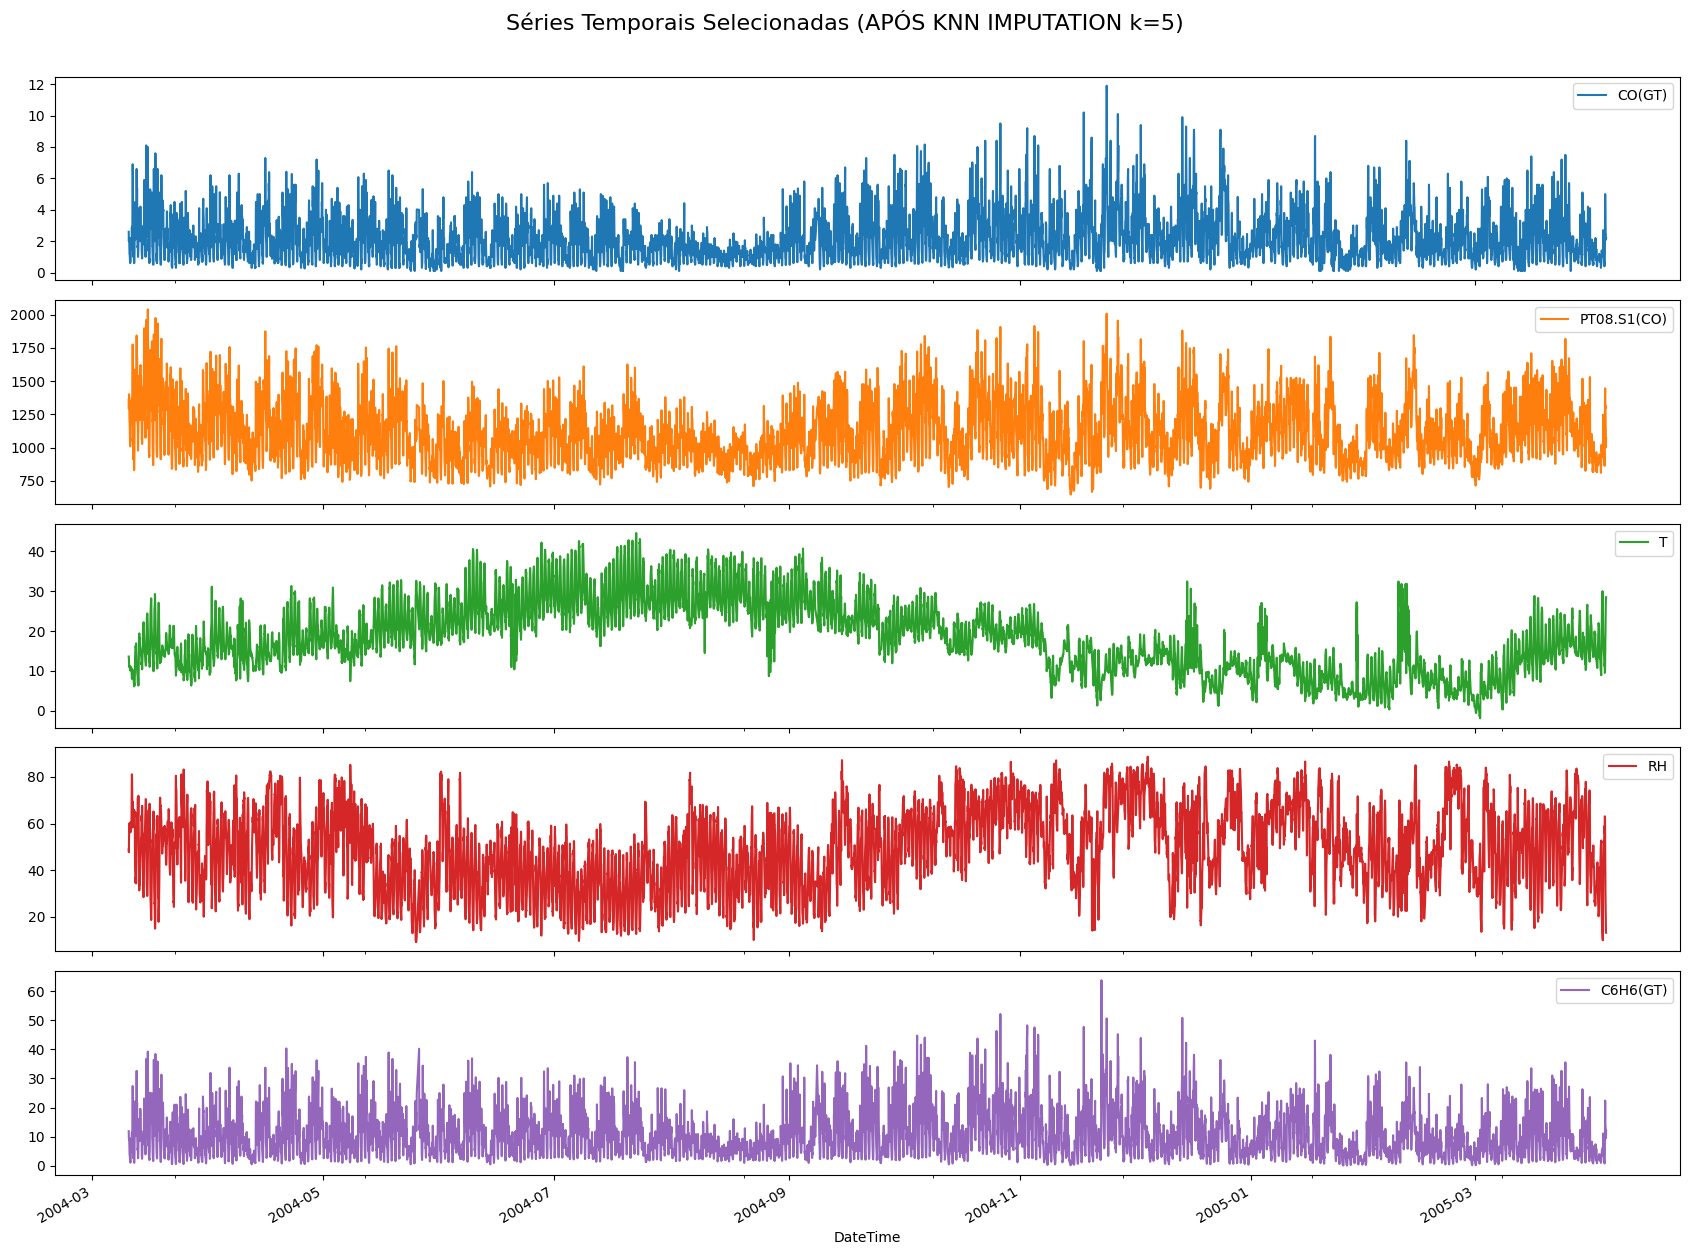

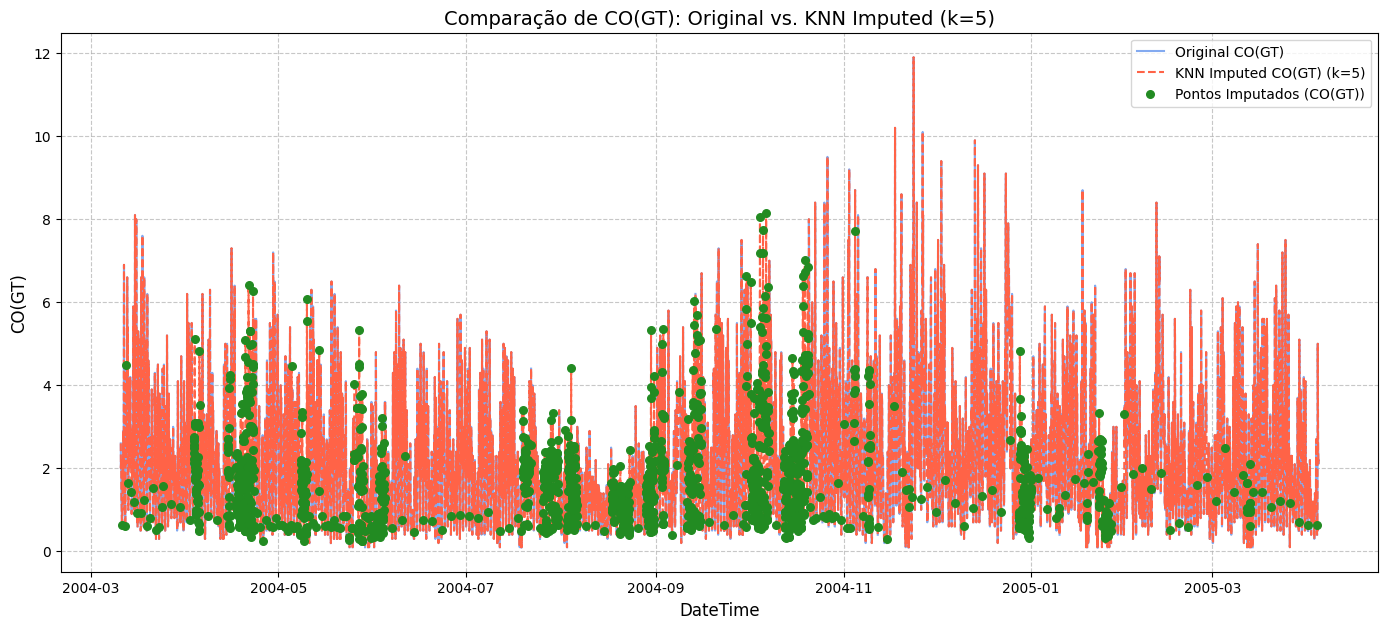


EDA e tratamento de dados faltantes com KNNImputer concluídos.


In [20]:
# --- ANÁLISE PÓS-IMPUTAÇÃO (KNN) ---
print("\n--- ANÁLISE PÓS-IMPUTAÇÃO (KNN) ---")
if not df_imputed_knn.empty:
    print("\nPrimeiras linhas do DataFrame imputado com KNN:")
    print(df_imputed_knn.head())
    print("\nInformações do DataFrame imputado com KNN:")
    df_imputed_knn.info()

    # Definir a lista de colunas para plotar, garantindo que existam no DataFrame
    cols_to_plot_ts_existing = ['CO(GT)', 'PT08.S1(CO)', 'T', 'RH', 'C6H6(GT)']
    cols_to_plot_ts_existing = [col for col in cols_to_plot_ts_existing if col in df_imputed_knn.columns and df_imputed_knn[col].notnull().any()]

    # Visualizar séries temporais após imputação com KNN
    if isinstance(df_imputed_knn.index, pd.DatetimeIndex) and cols_to_plot_ts_existing:
        df_imputed_knn[cols_to_plot_ts_existing].plot(subplots=True, figsize=(17, 2.5 * len(cols_to_plot_ts_existing)), layout=(-1, 1), sharex=True)
        plt.suptitle(f'Séries Temporais Selecionadas (APÓS KNN IMPUTATION k={k_neighbors})', y=1.00, size=16)
        plt.tight_layout(rect=[0, 0, 1, 0.99])
        plt.show()

        # Comparar uma variável antes e depois da imputação
        var_to_compare = 'CO(GT)' # Ou outra variável com faltantes significativos
        if var_to_compare in df.columns and var_to_compare in df_imputed_knn.columns and df[var_to_compare].isnull().any():
            plt.figure(figsize=(17, 7))

            # Plotar série original
            plt.plot(df.index, df[var_to_compare], label=f'Original {var_to_compare}', color='cornflowerblue', alpha=0.8, linestyle='-')

            # Plotar série imputada
            plt.plot(df_imputed_knn.index, df_imputed_knn[var_to_compare], label=f'KNN Imputed {var_to_compare} (k={k_neighbors})', color='tomato', linestyle='--')

            # Destacar os pontos que foram originalmente NaN e agora estão imputados
            original_nans_mask_compare = df[var_to_compare].isnull()
            if original_nans_mask_compare.any(): # Só plotar scatter se houver pontos imputados
                plt.scatter(df_imputed_knn.index[original_nans_mask_compare],
                            df_imputed_knn.loc[original_nans_mask_compare, var_to_compare],
                            color='forestgreen', marker='o', s=30, label=f'Pontos Imputados ({var_to_compare})', zorder=5)

            plt.title(f'Comparação de {var_to_compare}: Original vs. KNN Imputed (k={k_neighbors})', fontsize=14)
            plt.xlabel("DateTime", fontsize=12)
            plt.ylabel(var_to_compare, fontsize=12)
            plt.legend(fontsize=10)
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.show()
        else:
            print(f"Não foi possível plotar comparação para '{var_to_compare}'. "
                  "Coluna não existe, não tinha dados faltantes originais ou não está no dataframe imputado.")
    else:
        print("Não foi possível plotar séries temporais imputadas (índice não é DateTime, colunas não disponíveis ou DataFrame vazio).")
else:
    print("DataFrame imputado está vazio. Não há análises pós-imputação para mostrar.")

print("\nEDA e tratamento de dados faltantes com KNNImputer concluídos.")

## Justificativa Detalhada para o Uso do KNNImputer
1. Abordagem Multivariada:

 * O KNNImputer utiliza os valores de outras features (variáveis) para estimar os dados faltantes. Ele localiza as k amostras mais similares (vizinhas) à amostra com o valor faltante, baseando-se nas features que não estão faltantes. O valor imputado é então uma média (por padrão) dos valores da feature faltante nesses k vizinhos.
  * Porquê é adequado aqui: Este dataset de qualidade do ar contém múltiplas leituras de sensores e variáveis meteorológicas que são frequentemente intercorrelacionadas. Por exemplo, diferentes poluentes podem ter fontes comuns ou serem influenciados pelas mesmas condições atmosféricas (temperatura, umidade, vento). O KNNImputer pode capturar essas interdependências para realizar uma imputação mais informada do que métodos univariados (como interpolação simples ou preenchimento com média/mediana), que consideram cada coluna isoladamente.
2. **Preservação da Estrutura dos Dados e Relações:**

* Ao considerar múltiplas features simultaneamente, o KNN tem o potencial de preservar melhor a estrutura de variância e covariância dos dados em comparação com métodos univariados simples. Métodos mais simples podem reduzir a variância e atenuar as correlações existentes entre as variáveis.
* Porquê é importante: Manter a estrutura original dos dados é crucial para a validade de análises subsequentes, como modelagem preditiva ou inferência estatística. Distorcer essas relações pode levar a conclusões ou modelos equivocados.

3. **Natureza Não Paramétrica:**

* O KNNImputer não faz suposições sobre a distribuição estatística subjacente dos dados (por exemplo, não assume que os dados seguem uma distribuição normal).
Porquê é vantajoso: Muitas variáveis ambientais, como concentrações de poluentes, frequentemente exibem distribuições assimétricas ou complexas.
* Métodos não paramétricos como o KNN são mais flexíveis e robustos para lidar com tais dados.

4. Capacidade de Lidar com Relações Complexas (limitada):

* A abordagem baseada em vizinhança do KNN pode, até certo ponto, capturar relações não lineares entre variáveis que uma simples interpolação linear não conseguiria. A eficácia disso depende da métrica de distância utilizada e da densidade dos dados no espaço de features.
* **Porquê é relevante:** As interações entre diferentes poluentes, e entre poluentes e fatores meteorológicos, podem ser não lineares e complexas.



## **Considerações Práticas ao Usar KNNImputer (e como foram abordadas):**

* Escalonamento de Features:

  * Problema: O KNN utiliza métricas de distância (como a distância Euclidiana por padrão) para encontrar os vizinhos mais próximos. Se as features tiverem escalas muito diferentes (e.g., temperatura variando em dezenas, enquanto concentrações de um gás variam em centenas ou milhares), as features com magnitudes maiores dominarão o cálculo da distância, levando a uma seleção de vizinhos enviesada.
  * Solução Adotada: Os dados numéricos foram escalonados usando StandardScaler (que transforma os dados para terem média zero e desvio padrão unitário) antes de aplicar o KNNImputer. Após a imputação, os dados foram revertidos para sua escala original usando inverse_transform do scaler.

* Escolha de k (Número de Vizinhos):

  * **Importância:** O valor de k é um hiperparâmetro crucial. Um k muito pequeno pode tornar as imputações excessivamente sensíveis ao ruído nos dados dos vizinhos individuais. Um k muito grande pode suavizar demais as imputações, fazendo com que o valor imputado se aproxime de uma média mais global dentro de uma vizinhança ampla, perdendo nuances locais.
  * **Abordagem Adotada:** Foi utilizado k=5. Este é um valor comum e geralmente um bom ponto de partida. Em um contexto de modelagem preditiva, k seria idealmente otimizado usando técnicas como validação cruzada. Para fins de EDA e demonstração da técnica, 5 é um valor razoável.

* Custo Computacional:

  * **Desafio:** Encontrar os k vizinhos mais próximos pode ser computacionalmente intensivo para datasets com um número muito grande de amostras (n_samples) ou um número muito grande de features (n_features).
  * **Relevância para este Dataset:** O dataset AirQualityUCI tem aproximadamente 9357 amostras e cerca de 12-13 features (após o pré-processamento). Para este tamanho, o KNNImputer é computacionalmente viável.

* ***Manejo de Dados Não Numéricos:***

  * **Limitação:** A implementação padrão do KNNImputer no scikit-learn é projetada para dados numéricos.
  * **Abordagem Adotada:** O KNNImputer foi aplicado apenas às colunas numéricas do DataFrame. As colunas não numéricas (se houvesse, após o tratamento de Data/Hora) seriam mantidas separadas e reunidas após a imputação. Neste dataset, após a conversão de Data e Hora para o índice, todas as colunas remanescentes são ou deveriam ser numéricas.
  


Em resumo, o KNNImputer oferece uma abordagem mais sofisticada e potencialmente mais precisa para a imputação de dados faltantes neste contexto, em comparação com métodos univariados, devido à sua capacidade de alavancar as inter-relações entre as diversas medições de qualidade do ar e meteorológicas. A necessidade de pré-processamento (escalonamento) e a escolha cuidadosa de k são as principais considerações para sua aplicação eficaz.